# **Complete LoRA Fine-Tuning Notebook**

### **LoRA Fine-Tuning Readme:**

For more information on LoRA Fine-Tuning, refer to the [LoRA Fine-Tuning Readme](../lora_finetuning_readme.md).

### **About This Notebook:**

This notebook serves as a `complete version notebook` for LoRA Fine-Tuning. For a more concise and `simplified alternative`, refer to the [LoRA Fine-Tuning Notebook](lora_finetuning.ipynb).

During its execution, two reusable Python files are generated to facilitate future fine-tuning tasks. These files are applicable not only to `LoRA Fine-Tuning` but also to other fine-tuning approaches such as `Full Fine-Tuning`, `DDP`, `MP`, and `FSDP`.

### **Supporting Python Files:**

 - `my_login.py`: Contains reusable login functions (e.g., for Hugging Face and Weights & Biases). Created within this notebook. 
 - `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created within this notebook.

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The specific configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 150GB (model checkpoints storage)
- `GPU Setup`: 1 Nvidia A6000 GPU (48GB VRAM)

---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook


Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Pre-training**

## 2.1 Log in to Required Accounts (e.g., Hugging Face, Weights & Biases) 

Instead of calling the login functions directly within this Jupyter notebook, we save them externally in `my_login.py`. This approach allows these functions to be used not only for the current LoRA fine-tuning but also to be reused in other fine-tuning settings, such as Full Fine-Tuning, DDP, MP, and FSDP.


In [1]:
%%writefile my_login.py   
#--------------- Hugging Face and Weights & Biases login functions ---------------
# 1) Hugging Face account login 
# !pip install huggingface_hub==0.25.1 -q -U      
from huggingface_hub import login
def login_hf():
    print(f'==> Logging in to Hugging Face...')
    login('your Hugging Face Access Token')  # Replace with your real Hugging Face token

# 2) Weights & Biases account login
# !pip install wandb==0.18.1
import wandb
def login_wandb():
    print(f'==> Logging in to Weights & Biases...')
    wandb.login(key='your WandB API key')  # Replace with your real Weights & Biases API key

Writing my_login.py


In [2]:
import my_login

# Log in to the Hugging Face account to access the Idefics2 model and the dataset
my_login.login_hf()

# Log in to the Weights & Biases account to enable tracking of training progress
my_login.login_wandb()

==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 2.2 Load the Processor (Tokenizer) and the Base Model

Similar to the login functions, we save all utility functions externally in `my_utils.py`.


In [3]:
%%writefile my_utils.py  
#--------------- Processor and Base Model ---------------
# 1) Load processor
# !pip install transformers==4.46.0 -q -U
from transformers import AutoProcessor
def load_processor(model_path='HuggingFaceM4/idefics2-8b'):
    print(f'==> Loading processor...')
    processor = AutoProcessor.from_pretrained(
        pretrained_model_name_or_path=model_path,
        do_image_splitting=False                   # No image splitting in order to reduce memory usage
    )
    return processor

# 2) Load model
# !pip install hf_transfer==0.1.8 -q -U 
# !pip install accelerate==0.34.2 -q -U
# !pip install flash-attn==2.6.3 -q -U
import os
import torch
from transformers import Idefics2ForConditionalGeneration
def load_model(model_path='HuggingFaceM4/idefics2-8b', device_map='auto', quantization_config=None):
    print(f'==> Loading model...')
    # Enable HF_TRANSFER to optimize data transfer from the Hugging Face Hub
    os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
    model = Idefics2ForConditionalGeneration.from_pretrained(
        pretrained_model_name_or_path=model_path,
        # If device_map='auto', the accelerate library automatically distributes the model across devices in the order: GPU0 -> GPU1 -> CPU -> disk.
        device_map=device_map,
        # Use torch.bfloat16 (supported by Ampere architecture GPUs) to save VRAM. The default data type is torch.float32.
        torch_dtype=torch.bfloat16,
        # "flash_attention_2" significantly reduces VRAM usage and improves the efficiency of LLaMA architecture models.
        # For QLoRA, mixed precision issues were encountered, so the 'eager' attention implementation is used instead, providing moderate VRAM savings.
        attn_implementation='eager' if quantization_config else 'flash_attention_2',
        # Enable the quantization configuration when using QLoRA.
        quantization_config=quantization_config,
        # Use the default cache directory specified by the Hugging Face library.
        cache_dir=''
    )
    return model

# 3) Print brief model info to the terminal and save detailed model info to a file
import os
def print_model_info_to_file(model, filename):
    print(f'==> Printing model info...')
    filepath = os.path.dirname(filename)
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    file = open(filename, 'w')
    print(f'==> Model type: {type(model).__name__}')
    print(f'==> Model is located on device: {model.device}')
    # If model is not on CPU, print how model layers are distributed on GPUs
    print(f"==> Model device map: {getattr(model, 'hf_device_map', 'All layers are on CPU')}")
    print(f'==> For complete model info (type, architecture, config, generation config, device map), refer to {filename}.')
    file.write(f'==> Model type: {type(model).__name__}\n')
    file.write(f'==> Model architecture: {model}\n')
    # model.config includes bos_token_id, eos_token_id, max_position_embeddings, vocab_size, etc.
    file.write(f'==> Model config: {model.config}\n')
    # model.generation_config includes bos_token_id, eos_token_id, max_length, pad_token_id, temperature, etc.
    file.write(f'==> Model generation config: {model.generation_config}\n')
    file.write(f'==> Model is located on device: {model.device}\n')
    file.write(f"==> Model device map: {getattr(model, 'hf_device_map', 'All layers are on CPU')}\n")
    file.close()

# 4) Print model parameter samples to the terminal and save the complete model parameter info to a file
def print_model_parameters_to_file(model, filename):
    print(f'==> Printing model parameters...')
    filepath = os.path.dirname(filename)
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    file = open(filename, 'w')
    trainable_parameter = 0
    non_trainable_parameter = 0
    display_size = 15
    total_block = len(list(model.named_parameters()))
    for idx, (n, p) in enumerate(model.named_parameters()):
        # Print the first and last 15 blocks' parameters as samples to the terminal
        if idx < display_size or idx > total_block - display_size:
            print(f'{n} ({p.numel()}, {p.dtype}, {p.device.type}, {p.requires_grad})')
        # Print all model parameters to the file
        file.write(f'{n} ({p.numel()}, {p.dtype}, {p.device.type}, {p.requires_grad})\n')
        if p.requires_grad:
            trainable_parameter += p.numel()
        else:
            non_trainable_parameter += p.numel()
    total_parameter = trainable_parameter + non_trainable_parameter
    print(f'==> Total parameters: {total_parameter}, Trainable parameters: {100 * trainable_parameter / total_parameter}%')
    print(f'==> Parameters in the first {display_size} blocks and the last {display_size} blocks are displayed here. For complete model parameter info, refer to {filename}.')
    file.write(f'==> Total parameters: {total_parameter}, Trainable parameters: {100 * trainable_parameter / total_parameter}%\n')
    file.close()

# 5) Print brief processor info to the terminal and save detailed processor info to a file
def print_processor_info_to_file(processor, filename):
    print(f'==> Printing processor info...')
    filepath = os.path.dirname(filename)
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    file = open(filename, 'w')
    print(f'==> Regular token count: {processor.tokenizer.vocab_size}, regular+special token count: {len(processor.tokenizer)}, bos_token: {processor.tokenizer.bos_token}, eos_token: {processor.tokenizer.eos_token}, pad_token: {processor.tokenizer.pad_token}')
    print(f'==> For complete processor info, refer to {filename}.')
    file.write(f'==> Regular token count: {processor.tokenizer.vocab_size}, regular+special token count: {len(processor.tokenizer)}, bos_token: {processor.tokenizer.bos_token}, eos_token: {processor.tokenizer.eos_token}, pad_token: {processor.tokenizer.pad_token}\n')
    file.write(f'==> Processor info: {processor}\n')
    file.close()


Writing my_utils.py


In [4]:
import my_utils

# Load processor
processor = my_utils.load_processor()
my_utils.print_processor_info_to_file(processor, './results/model_info/original_processor_info.txt')

# Load model
base_model = my_utils.load_model()
my_utils.print_model_info_to_file(base_model, './results/model_info/base_model_info.txt')
my_utils.print_model_parameters_to_file(base_model, './results/model_info/base_model_parameters.txt')

==> Loading processor...


processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32003, bos_token: <s>, eos_token: </s>, pad_token: <unk>
==> For complete processor info, refer to ./results/model_info/original_processor_info.txt.
==> Loading model...


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/base_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, True)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.k_proj.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.v_proj.weight (1327104, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.v_proj.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.encoder.lay

## 2.3 Load the Dataset and (Optional) Perform Dry Runs for Tokenization

In [5]:
%%writefile -a my_utils.py

#--------------- Hugging Face Dataset ---------------
#1) Load dataset (source: https://huggingface.co/datasets/xugefu/MuseQuest)
# !pip install datasets==3.0.0 -q -U
from datasets import load_dataset
def load_hf_dataset(hf_path="xugefu/MuseQuest"):
    print(f'==> Loading hf dataset...')
    dataset = load_dataset(path=hf_path)
    return dataset

Appending to my_utils.py


In [6]:
import importlib

# Reload my_utils.py to access newly added functions
importlib.reload(my_utils)

# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

==> Loading hf dataset...


README.md:   0%|          | 0.00/648 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/82 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/74 [00:00<?, ? examples/s]

### **(Optional 1) Tokenize a JSON Format Message with the Processor:**

#### Example JSON format message:
```json
[
    { 
        "role": "user", 
        "content": [
            {"type": "image"},
            {"type": "text", "text": "xxx"}
        ]
    }
]  
```

#### Example Variable States During Tokenization:
```text
user_msg_formatted:                            'User:<image>xxx<end_of_utterance>'
user_msg_formatted_with_next_prompt:           'User:<image>xxx<end_of_utterance>\nAssistant:'
tokens:                               tokenize('User:<image>xxx<end_of_utterance>\nAssistant:')
```

In [7]:
print(f'==> (Optional 1) Tokenizing a JSON format message...')

# Define a JSON format message
messages = [{ 
    "role": "user", 
    "content": [
        {"type": "image"},
        {"type": "text", "text": "xxx"}
    ]
}]

# Tokenize this JSON format message with different settings
user_msg_formatted = processor.apply_chat_template(messages, tokenize=False)
user_msg_formatted_with_next_prompt = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
tokens = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=True)

# Display results
print(f'==> Original JSON format message: {messages}')
print(f'==> User message (text): {user_msg_formatted}')
print(f'==> User message + assistant prompt (text): {user_msg_formatted_with_next_prompt}')
print(f'==> User message + assistant prompt (tokens): {tokens}')

==> (Optional 1) Tokenizing a JSON format message...
==> Original JSON format message: [{'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'xxx'}]}]
==> User message (text): User:<image>xxx<end_of_utterance>

==> User message + assistant prompt (text): User:<image>xxx<end_of_utterance>
Assistant:
==> User message + assistant prompt (tokens): [1247, 28747, 32001, 1318, 5735, 32002, 28705, 13, 7226, 11143, 28747]


### **(Optional 2) Tokenize a Record in the Dataset with the Processor:**

#### Example Record from the Dataset:
```json
{
  "messages": [
    {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": "xxx"}]},
    {"role": "assistant", "content": [{"type": "text", "text": "yyy"}]}
  ]
}
```

#### Example Variable States During Tokenization:
```text
user_msg:                                       {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'xxx'}]}
assistant_msg:                                  {"role": "assistant", "content": [ {"type": "text", "text": "yyy"} ]}
user_msg_formatted_with_next_prompt:             'User:<image>xxx<end_of_utterance>\nAssistant:'
tokens:                                 tokenize('User:<image>xxx<end_of_utterance>\nAssistant:')
decoded_tokens:                                 ['User', ':', '<image>', 'x', 'x', 'x', '<end_of_utterance>', '', '\n', 'Ass', 'istant', ':']                                 
tokenized_input:         pytorch_tensor(tokenize('User:<image>xxx<end_of_utterance>\nAssistant:'))
decoded_tokenized_input:                    ['<s> User:<fake_token_around_image><image><image>...<image><fake_token_around_image>xxx<end_of_utterance> \nAssistant:']
```

==> (Optional 2) Tokenizing a record in dataset...


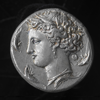

==> Original user message in record: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> Original assistant message in record: {'role': 'assistant', 'content': [{'type': 'text', 'text': "The exhibit features the Syracuse dekadrachm, a remarkable coin from antiquity renowned for its exquisite artistry and high relief, crafted by notable designers like Kimon and Euinatos. This coin has captivated enthusiasts for over 2,500 years, raising questions about how the ancient Greeks achieved such beauty using only hand tools. An interesting connection to American history is found in Theodore Roosevelt, who, while known for his political reforms, also sought to enhance American coinage. Disappointed by the mundane designs of contemporary coins, he envisioned a more artistic approach that would rival the elegance of classical pieces like the dekadrachm. Roosevelt's passion led him to collaborate with sculptor Augustus Saint-Gaudens, res

In [8]:
import json

print(f'==> (Optional 2) Tokenizing a record in dataset...')

# Load and display the first test record's image (resized)
record = dataset["test"][0]
image = record['image']
image_resized = image.resize((100, 100))
image_resized.show()

# Parse dialog messages from the record
dialog_json = json.loads(record['dialog'])
user_msg = dialog_json['messages'][0]
assistant_msg = dialog_json['messages'][1]
# Tokenize the user message with different settings
user_msg_formatted_with_next_prompt = processor.apply_chat_template([user_msg], add_generation_prompt=True, tokenize=False)
tokens = processor.apply_chat_template([user_msg], add_generation_prompt=True, tokenize=True)
decoded_tokens = [processor.tokenizer.decode([token_id], skip_special_tokens=False) for token_id in tokens]
tokenized_input = processor(text=user_msg_formatted_with_next_prompt, images=[image], return_tensors="pt")
decoded_tokenized_input = [processor.tokenizer.decode(token_list, skip_special_tokens=False) for token_list in tokenized_input['input_ids']]

# Display results
print(f'==> Original user message in record: {user_msg}')
print(f'==> Original assistant message in record: {assistant_msg}')
print(f'==> User message + assistant prompt (text): {user_msg_formatted_with_next_prompt}')
print(f'==> User message + assistant prompt (tokens): {tokens}')
print(f'==> User message + assistant prompt (decoded tokens): {decoded_tokens}')
print(f'==> User message + assistant prompt + image content inserted (pytorch tensors): {tokenized_input}')
print(f'==> User message + assistant prompt + image content inserted (decoded pytorch tensors): {decoded_tokenized_input}')


## 2.4 Perform Inference with the Base Model to Establish a Baseline

In [9]:
%%writefile -a my_utils.py

#--------------- Inferencing ---------------
# 1) Calculate semantic similarity score between two sentence batches
#   Note: Although this function supports sentence batches, in our use case, we calculate a score between 2 sentences only
def calculate_semantic_similarity_score(model, processor, sentence_batch1, sentence_batch2):
    # Tokenizing sentence_batch1 (e.g., generated answer batch) and sentence_batch2 (e.g., ground truth batch)
    # sentence_batch_pt['input_ids'] dimensions: (batch_size, sequence_length)
    sentence_batch1_pt = processor(text=sentence_batch1, return_tensors="pt").to(model.device)
    sentence_batch2_pt = processor(text=sentence_batch2, return_tensors="pt").to(model.device)

    # Get sentence_batch1 and sentence_batch2 contextual embeddings through a model forward pass; embedding is from the last hidden layer
    # embedding_vec dimensions: (batch_size, hidden_size)
    with torch.no_grad():
        embedding_vec_batch1 = model(**sentence_batch1_pt, output_hidden_states=True).hidden_states[-1].mean(dim=1)
        embedding_vec_batch2 = model(**sentence_batch2_pt, output_hidden_states=True).hidden_states[-1].mean(dim=1)

    # Calculate semantic similarity score (cosine similarity) for each record in sentence_batch1 and sentence_batch2
    # cosine_sim dimensions: (batch_size), value range: float[1, -1]
    cosine_sim = torch.cosine_similarity(embedding_vec_batch1, embedding_vec_batch2, dim=1)
    # Calculate overall semantic similarity score for sentence_batch1 and sentence_batch2 at the batch level
    # semantic_loss dimensions: (1), value range: float[0, 2]
    semantic_loss = 1.0 - cosine_sim.mean()
    return semantic_loss

# 2) Batch inference, save image thumbnails, and save inference results to a CSV file
# Note: The saved image thumbnails and the CSV file will be used in plot_similarity_scores() next step
import pandas as pd
import json
def batch_inference_model(model, processor, dataset, report_csv, batch_size=4):
    print(f'==> Performing batch inference and saving results to {report_csv} ...')
    
    # Prepare directories for image thumbnails and CSV file
    report_csv_dir = os.path.dirname(report_csv)
    thumbnail_dir = os.path.join(report_csv_dir, 'thumbnail')
    if not os.path.exists(report_csv_dir):
        os.makedirs(report_csv_dir)
    if not os.path.exists(thumbnail_dir):
        os.makedirs(thumbnail_dir)

    # Start inference
    model.eval()  # model.eval() disables dropout and switches batch norm to use batch statistics instead of accumulated statistics
    model.config.use_cache = True  # Enable cache to speed up token-by-token generation
    report_df = pd.DataFrame(columns=['data_id', 'item_name', 'image_name', 'user_question', 'model_generated_answer', 'ground_truth_answer', 'semantic_similarity_score'])
    accumulated_semantic_similarity_score = 0
    with torch.no_grad():  # Disable gradient tracking to reduce VRAM usage
        total_batch = (len(dataset) - 1) // batch_size + 1  # Calculate total number of batches
        batch_data = []
        for i, dataset_data in enumerate(dataset):
            batch_data.append(dataset_data)
            # If batch_data[] is full or we reach the last data point, start inference
            if len(batch_data) == batch_size or i == len(dataset) - 1:
                cur_batch_idx = i // batch_size
                print(f'==> [Batch: {cur_batch_idx + 1}/{total_batch}] Data in batch: {len(batch_data)}')
                # Save thumbnails of current batch
                batch_image = [[data['image']] for data in batch_data]
                batch_image_resized = [data['image'].resize((100, 100)) for data in batch_data]
                batch_thumbnail = [data['image'].resize((20, 20)) for data in batch_data]
                for idx, data in enumerate(batch_data):
                    batch_thumbnail[idx].save(os.path.join(thumbnail_dir, data["image_name"]))
                # Tokenize 'user message + image' for the current batch
                batch_dialog_json = [json.loads(data['dialog']) for data in batch_data]
                batch_user_msg = [dialog_json['messages'][0] for dialog_json in batch_dialog_json]
                batch_assistant_msg = [dialog_json['messages'][1] for dialog_json in batch_dialog_json]
                batch_user_question = [user_msg['content'][1]['text'] for user_msg in batch_user_msg]
                batch_ground_truth_answer = [assistant_msg['content'][0]['text'] for assistant_msg in batch_assistant_msg]
                batch_user_msg_formatted_with_next_prompt = [  # 'User:<image>xxx<end_of_utterance>\nAssistant:'
                    processor.apply_chat_template([user_msg], add_generation_prompt=True, tokenize=False)
                    for user_msg in batch_user_msg
                ]
                batch_tokenized_input = processor(
                    text=batch_user_msg_formatted_with_next_prompt,
                    images=batch_image,
                    return_tensors="pt",
                    padding=True  # Padding to the longest sequence in the batch
                ).to(model.device)
                
                # Run batch inference
                batch_generated_output = model.generate(**batch_tokenized_input, max_new_tokens=512)
                batch_generated_text = processor.batch_decode(batch_generated_output, skip_special_tokens=True)
                
                # Process inference results
                for idx, data in enumerate(batch_data):
                    # Display inference result (generated answer) and evaluate it against ground truth using semantic similarity scores
                    generated_answer = batch_generated_text[idx].split('Assistant:')[1].strip()
                    semantic_similarity_score = calculate_semantic_similarity_score(model, processor, generated_answer, batch_ground_truth_answer[idx])
                    print(f'==> [Batch: {cur_batch_idx + 1}/{total_batch}][Data: {idx + 1}/{len(batch_data)}] Inference for data_id: {data["data_id"]}, item_name: {data["item_name"]}, image_name: {data["image_name"]}:')
                    batch_image_resized[idx].show()
                    print(f'==> Original user message: {batch_user_msg[idx]}')
                    print(f'==> User message + assistant prompt (text): {batch_user_msg_formatted_with_next_prompt[idx]}')
                    print(f'==> Model generated answer: {generated_answer}')
                    print(f'==> Ground truth answer: {batch_ground_truth_answer[idx]}')
                    print(f'==> Semantic similarity score: {semantic_similarity_score}')
                    
                    # Save results in the CSV file
                    data_df = pd.DataFrame([{'data_id': data['data_id'],
                                             'item_name': data['item_name'],
                                             'image_name': data['image_name'],
                                             'user_question': batch_user_question[idx],
                                             'model_generated_answer': generated_answer,
                                             'ground_truth_answer': batch_ground_truth_answer[idx],
                                             'semantic_similarity_score': semantic_similarity_score.item()}])
                    report_df = pd.concat([report_df, data_df], ignore_index=True)
                    accumulated_semantic_similarity_score += semantic_similarity_score.item()
                batch_data = []  # Clear batch_data[] for the next batch run
                torch.cuda.empty_cache()  # Free GPU VRAM after each batch
                
    # Calculate and save average similarity score for the dataset
    ave_semantic_similarity_score = round(accumulated_semantic_similarity_score / len(dataset), 3)
    print(f'==> Average semantic similarity score: {ave_semantic_similarity_score} (0 is the best, 2 is the worst)')
    report_df = pd.concat([report_df, pd.DataFrame([{'item_name': 'average_semantic_similarity_score', 'semantic_similarity_score': ave_semantic_similarity_score}])], ignore_index=True)
    report_df.to_csv(report_csv, index=False, encoding='utf-8')
    torch.cuda.empty_cache()  # Clean up GPU VRAM after all batch inferences are complete

# 3) Plot multiple inference run results in a diagram
# !pip install matplotlib==3.9.2 -q -U
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def plot_similarity_scores(inference_result_csv_list, thumbnail_dir=None, plot_file_name='./results/inference_results/default_plot.jpg'):
    # Note1: inference_result_csv_list format example: [('inference_run_tag1', 'inference_result1.csv'), ('inference_run_tag2', 'inference_result2.csv'), ...]
    # Note2: thumbnail_dir is the directory created during batch_inference_model() execution
    # Note3: y-axis: df['data_id'], x-axis: df['semantic_similarity_score'], y-tick: df['data_id'] + df['item_name'], legend: inference_run_tag

    print(f'==> Plotting similarity scores...')
    ytick_dict = {}  # Union lookup table for all inference results: key: df['data_id'], value: df['data_id'] + df['item_name']
    image_dict = {}  # Union lookup table for all inference results: key: df['data_id'], value: df['image_name']
 
    fig, ax = plt.subplots(figsize=(8, 30))    
    # Plot 1 curve from 1 CSV file
    for inference_run_tag, inference_result_csv in inference_result_csv_list:
        df = pd.read_csv(inference_result_csv)        
        # 1. Extract average similarity score from the last row, then remove the last row to keep all rows uniform
        ave_semantic_similarity_score = df['semantic_similarity_score'].iloc[-1]
        df_trimmed = df.iloc[:-1]
        # 2. Sort by 'data_id' for y-axis, plot (y, x) curve, and plot a reference line using average similarity score
        df_sorted = df_trimmed.sort_values(by='data_id')
        x = df_sorted['semantic_similarity_score']
        y = df_sorted['data_id']
        lines = ax.plot(x, y, marker='o', linestyle='-', label=inference_run_tag)
        ax.axvline(x=ave_semantic_similarity_score, color=lines[0].get_color(), linestyle='--', label=f'{inference_run_tag}(ave)={ave_semantic_similarity_score:.3f}')
        # 3. Update y-tick info and image info in lookup tables
        ytick = '[' + df_sorted['data_id'].astype(int).astype(str) + '] ' + df_sorted['item_name']
        ytick_dict.update(dict(zip(y, ytick)))
        image_dict.update(dict(zip(y, df_sorted['image_name'])))

    # Figure title and global settings
    plt.title('Semantic Similarity Score Comparison')                     # Set figure title
    ax.axvline(x=0, color='red', linestyle='--', label='ground_truth=0')  # Add a reference line for ground truth
    ax.legend()                                                           # Show legend
    # x-axis settings
    plt.xlim(-0.2, 0.8)                                                   # Set x-axis range
    plt.xlabel('Semantic Similarity Score')                               # Set x-axis label
    # y-axis settings
    plt.ylabel('Item')                                                    # Set y-axis label
    y_of_all_plots = sorted(ytick_dict.keys())                            # All y values (from df['data_id'])
    yticks_of_all_plots = [ytick_dict[y] for y in y_of_all_plots]         # All y-ticks (from df['data_id'] + df['item_name'])
    plt.yticks(y_of_all_plots, yticks_of_all_plots)                       # Attach y-ticks to y-axis   
    for data_id, image_name in image_dict.items():                        # Attach thumbnails (if available, from df['image_name']) next to y-axis
        image_path_name = os.path.join(thumbnail_dir, image_name)
        if os.path.exists(image_path_name):
            img = plt.imread(image_path_name)
            imagebox = OffsetImage(img, zoom=1)
            ab = AnnotationBbox(imagebox, (-0.15, data_id), frameon=False)
            ax.add_artist(ab)
        else:
            print(f"Image file {image_path_name} not found. Skipping.")
    # Save and show the figure
    plt.savefig(plot_file_name, bbox_inches='tight')                      # Use tight bounding box to avoid cut off
    plt.show()                                                            # Display figure; plt.show() clears the figure, so we save figure before this step


Appending to my_utils.py


==> Performing batch inference and saving results to ./results/inference_results/inference_results_before_finetuning.csv ...
==> [Batch: 1/6] Data in batch: 14
==> [Batch: 1/6][Data: 1/14] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


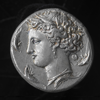

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a coin.
==> Ground truth answer: The exhibit features the Syracuse dekadrachm, a remarkable coin from antiquity renowned for its exquisite artistry and high relief, crafted by notable designers like Kimon and Euinatos. This coin has captivated enthusiasts for over 2,500 years, raising questions about how the ancient Greeks achieved such beauty using only hand tools. An interesting connection to American history is found in Theodore Roosevelt, who, while known for his political reforms, also sought to enhance American coinage. Disappointed by the mundane designs of contemporary coins, he envisioned a more artistic approach that would rival the elegance of classical pieces like the dekadrachm. Roosevelt's

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


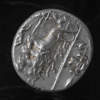

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a coin.
==> Ground truth answer: This exhibit highlights the Syracuse dekadrachm, a stunning ancient coin that exemplifies the artistry of its time, designed by renowned craftsmen such as Kimon and Euinatos. With its striking high relief, this coin has fascinated collectors for more than two millennia, prompting inquiries into the techniques used by the Greeks to achieve such intricate designs without modern tools. A significant figure connected to this coin is Theodore Roosevelt, who, while recognized for his political reform efforts, also sought to elevate the quality of American currency. Frustrated by the lackluster designs of contemporary coins, he advocated for a more artistic 

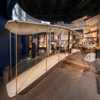

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A full size replica of the Wright brothers first airplane is on display with photos and videos of the brothers flying in the background.
==> Ground truth answer: This exhibit showcases the remarkable 1903 Wright Flyer, the first successful powered airplane, which heralded the beginning of the aerial age. Designed by Wilbur and Orville Wright, this biplane features a 12-horsepower Wright horizontal four-cylinder engine that drives two pusher propellers through a chain-and-sprocket transmission. Notably, it employs linear skids for landing gear and is finished with natural fabric, devoid of any sealant or paint. The Wright brothers' groundbreaking achievement on December 17, 1903, at Kitty Hawk, North Carolina, i

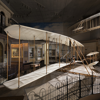

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A collection of old fashioned planes are on display in a museum.
==> Ground truth answer: The exhibit features the iconic 1903 Wright Flyer, a pioneering aircraft that marked the dawn of powered flight. Built by the Wright brothers, Wilbur and Orville, this biplane is powered by a 12-horsepower engine that operates two pusher propellers via a sprocket-and-chain system. Its unique landing gear consists of linear skids, and it is covered in natural fabric, without any paint or sealant. The Flyer made its historic first flight on December 17, 1903, in Kitty Hawk, North Carolina, with Orville at the controls for a brief 12-second journey. The Wrights' innovative methods, including wind tunnel te

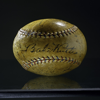

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a ball on the surface.
==> Ground truth answer: This exhibit features a remarkable autographed baseball from the legendary 1926 New York Yankees, signed by iconic players including Hall of Famers Babe Ruth and Lou Gehrig. Ruth, known for his extraordinary hitting prowess, and Gehrig, celebrated for his record of 2,130 consecutive games played, both left an indelible mark on the sport. Gehrig's battle with amyotrophic lateral sclerosis (ALS), which is often referred to as Lou Gehrig's disease, showcased his incredible humility and resilience, inspiring many during his illness. The baseball, which measures approximately 3 inches in diameter, is crafted with a cork center, wool layers, and

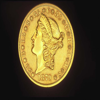

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a coin with some text and numbers on it.
==> Ground truth answer: This exhibit features a remarkable coin from the United States Mint in Philadelphia, showcasing a unique design that reflects a significant moment in American numismatic history. The obverse displays the Liberty head facing left, with the date inscribed below and details about weight and fineness surrounding it. The reverse features an eagle, similar to the standard twenty-dollar coin, but replaces the traditional motto "IN GOD WE TRUST" with "DEO EST GLORIA." This coin was part of a series inspired by the desire to enhance the competitiveness of American currency in global markets, alongside the creation of the four-doll

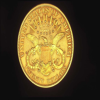

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a united states of america twenty dollars gold coin.
==> Ground truth answer: This exhibit highlights a significant gold coin minted by the United States Mint in Philadelphia, showcasing both artistic and economic significance. The coin features a Liberty head on the obverse, with the date inscribed below and weight and fineness details surrounding it. On the reverse, an eagle is depicted, but intriguingly, it bears the Latin phrase "DEO EST GLORIA" instead of the more familiar "IN GOD WE TRUST." This design was part of an initiative aimed at improving the international appeal and convertibility of American coins, paralleling the introduction of the four-dollar gold coin, or Stella. 

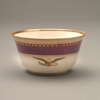

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This small cup has a purple band at the top and a design of an eagle on the front.
==> Ground truth answer: The exhibit features Abraham Lincoln's coffee cup, a poignant artifact from a pivotal moment in American history. This ceramic cup, adorned in purple with white and gold trim, was left behind by President Lincoln on a windowsill at the White House on the evening of April 14, 1865, just before he attended Ford's Theatre. A White House servant preserved this cup as a memento of that tragic night, which marked the end of Lincoln's life and the Civil War. In 1887, Captain D.W. Taylor gifted it to Robert Todd Lincoln, the president's eldest son, ensuring its legacy as a cherished family heirloom. The cup is no

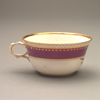

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This cup has a handle and is purple next to the gold.
==> Ground truth answer: This exhibit showcases a significant artifact: Abraham Lincoln's coffee cup, which dates back to 1887. The cup was a gift from Captain D.W. Taylor to Robert Todd Lincoln, the president's eldest son. It holds a somber history, as it was left behind by Lincoln on April 14, 1865, just before he went to Ford's Theatre for what would be his final evening. A White House servant preserved the cup, recognizing its importance as a relic of that fateful night. Crafted from ceramic and featuring a striking purple color with white and gold trim, the cup measures approximately 3 1/4 inches in height. It is housed at the Smiths

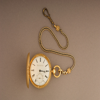

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A watch with a gold chain is on a gray surface.
==> Ground truth answer: This exhibit features a remarkable English gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite timepiece served as a notable emblem of his achievements as a lawyer. The watch's movement, crafted in Liverpool, represents the high-quality manufacturing of the era, while the case was made by an unidentified American artisan. Notably, this watch boasts one of the finest movements available in England, capable of maintaining accurate time to within seconds daily. A hidden narrative unfolds with engravings made by watchmaker 

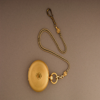

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: Gold watch with a chain that is 23 inches long.
==> Ground truth answer: This exhibit showcases Abraham Lincoln's gold pocket watch, acquired in the 1850s from a jeweler named George Chatterton in Springfield, Illinois. Although Lincoln was not typically seen as vain, the watch symbolized his professional success as a lawyer. The watch's movement was produced in Liverpool, a hub for watchmaking at the time, while the case was crafted by an unidentified American shop. Known for its exceptional quality, the watch's movement can keep time within seconds daily. A fascinating aspect of this piece is the hidden message engraved by watchmaker Jonathan Dillon, who, during repairs on April 12, 1861, 

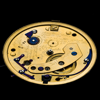

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a watch.
==> Ground truth answer: This display features an exquisite gold pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a prestigious symbol of his accomplishments as a lawyer. The watch's movement was manufactured in Liverpool, a center of watch production, and it is accompanied by a high-quality case made in America. Remarkably, this timepiece has a movement capable of keeping time to within seconds each day. An intriguing story lies within, as watchmaker Jonathan Dillon, while repairing the watc

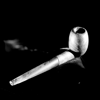

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image I can see a pipe on the table.
==> Ground truth answer: The exhibit features Albert Einstein's iconic pipe, dating back to around 1948. Known for his groundbreaking contributions to theoretical physics, including the theory of relativity, Einstein is also recognized for his distinctive appearance, which prominently included this pipe. Despite reducing his smoking due to medical advice in his later years, he cherished the physical sensation of holding a pipe. This particular pipe shows signs of extensive use, with a noticeable hole worn into its bit. It was gifted to Gina Plunguian, a close friend and admirer of Einstein, before being acquired by the Smithsonian in 1979. This artifact is part of a 

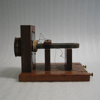

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a device that produces an electric current.
==> Ground truth answer: This exhibit at the National Museum of American History highlights the groundbreaking invention of the telephone by Alexander Graham Bell. On March 7, 1876, Bell was awarded the first patent for an apparatus designed to transmit vocal sounds telegraphically. Just three days later, he successfully communicated with his assistant, Thomas Watson, uttering the iconic words, “Mr. Watson, come here, I want to see you.” Featured in this exhibit is one of the original telephones used during a demonstration between Boston and Salem, Massachusetts, on November 26, 1876. This particular device is notable for its iron diaphragm and dual electromag

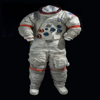

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a mannequin wearing a space suit.
==> Ground truth answer: This exhibit features the Apollo 17 spacesuit, which was worn during the final Apollo mission that successfully landed astronauts on the moon in 1972. Launched on December 7, 1972, aboard a Saturn V rocket, Apollo 17 included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, notable for being the only geologist to have walked on lunar soil. While Evans orbited the moon, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region, where they conducted extensive scientific activities over three days. They completed three moonwalks, collecting a remarkable 110 kil

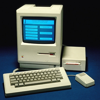

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The computer has a blue screen with several windows on it.
==> Ground truth answer: This exhibit features the iconic Apple "Classic" Macintosh Personal Computer, launched in 1984 by Apple Inc. This groundbreaking machine introduced a graphic user interface (GUI) to the world of personal computing, a concept that had its roots in the 1970s at Xerox's Palo Alto Research Center. Apple captured public attention with a memorable Super Bowl XVIII advertisement, marking the Macintosh's debut on January 22, 1984, with a retail price of approximately $2,500. Unlike previous computers that relied on command lines, the Macintosh allowed users to interact with programs through clickable icons, utilizing a single-button mou

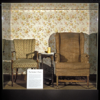

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a glass box. In this box there are two chairs. On this table there is a cup.
==> Ground truth answer: This exhibit features an iconic upholstered wing chair that was prominently used by the character Archie Bunker, portrayed by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, with its distinctive orange-yellow woven fabric and sturdy wooden frame, dates back to the 1940s, although its exact origins remain unclear. Initially acquired from a thrift store in Southern California, it served as a significant prop throughout the show's run from 1971 to 1979, until it was replaced by a reproduction in the final season after being donated to the Smithsonian. "All in the F

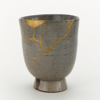

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This bowl is part of the collection of the Asian Art Museum of San Francisco. It is made of ceramic and measures 7 1/2 x 7 1/2 x 7 1/2 inches.
==> Ground truth answer: This exhibit features a remarkable 17th-century tea bowl from the Satsuma ware collection, specifically the White Satsuma type, hailing from Kagoshima prefecture in Japan during the Edo period. The bowl, made of stoneware and finished with a clear, crackled glaze, has a storied past, having been broken and subsequently repaired using the traditional Japanese art of kintsugi, or golden joinery. This technique not only mends the bowl but also accentuates its history by highlighting the cracks with lacquer infused with powdered gold. The lacquer, de

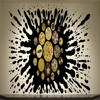

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting.
==> Ground truth answer: This exhibition features the captivating work of Yinka Shonibare, a prominent artist born in London in 1962. The display showcases 25 circular canvases of varying sizes, meticulously arranged over a large-scale ink splatter pattern that has been applied using a template. Each canvas is adorned with intricate foliate designs painted in black and gold, utilizing Dutch wax printed fabrics. Shonibare's earlier works are characterized by small square canvases in a grid layout, while his more recent pieces, including this one, challenge traditional boundaries with their dynamic black splatter forms. The artwork draws inspiration from Africa's oil resources, often referred 

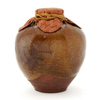

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a brown vase with a brown and red design on it.
==> Ground truth answer: The exhibit titled "Chigusa and the Art of Tea," located at the Arthur M. Sackler Gallery, delves into the intricate relationship between Japanese tea culture and the art of collecting. It highlights how collectors engaged with tea-leaf storage jars through the traditional tea ceremony, known as chanoyu, by bestowing names and adorning these jars with exquisite textiles. Central to this theme is the jar named Chigusa, which evolved from a simple Chinese import into a revered object of beauty and contemplation, while still retaining its functional purpose. Notably, 16th-century tea diaries provide insights into the admiration expres

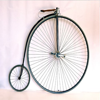

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A penny farthing bicycle is on display.
==> Ground truth answer: This exhibit at the National Museum of American History celebrates the arrival of spring with a spotlight on an original 1886 Columbia Light Roadster high-wheel bicycle. This remarkable artifact, which originally sold for around $135, was produced by the Pope Manufacturing Co., recognized as the first bicycle manufacturer in the United States. The bicycle features a distinctive configuration with a 53-inch front wheel, supported by 60 spokes, and an 18-inch rear wheel with 20 spokes, available in a range of sizes for riders. Accompanying this bicycle is a historic photograph showcasing one of America's inaugural organized biking tours from 1879, f

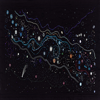

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This work is a large-scale embroidered piece that is mounted on a black fabric. The artist used different colors of threads to create a galaxy.
==> Ground truth answer: The exhibit titled “Milky Way, Starry Night # 2” features the work of Gwich'in artist Margaret Nazon, who hails from Tsiigehtchic in the Northwest Territories of Canada. Created in 2021, this piece reflects Nazon's lifelong fascination with the stars, a passion that she fully embraced in her art later in life after being inspired by Hubble Space Telescope imagery. Nazon's work is distinctive as it incorporates swirling galaxies, a departure from traditional Gwich'in beadwork, showcasing her unique artistic style. This artwork is part of the “Lig

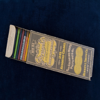

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a box which contains crayons.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights a pack of Crayola Crayons from 1903, celebrating a beloved back-to-school tradition. Invented by cousins Edwin Binney and C. Harold Smith, the crayons were crafted using paraffin wax and nontoxic pigments, making them safe and durable for young artists. The name "Crayola," created by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," referring to its waxy texture. This particular set, aimed at budding artists, features 28 vibrant colors, including celestial blue and rose pink, and is one of the earliest produced. The packaging, la

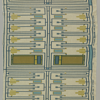

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a poster. In this poster we can see some text and some designs.
==> Ground truth answer: This exhibit features a striking piece designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. The textile, produced by F. Schumacher & Co., a New York-based manufacturer established in 1889, showcases a captivating geometric pattern composed of rectangular blocks in shades of light blue and various olive tones, intricately connected by fine lines of darker blue against an off-white backdrop. The length of the printed linen measures 120 by 57.5 cm (47 1/4 by 22 5/8 inches), with a repeat height of 63.5 cm (25 inches). Additionally, five alternate colorways of this design are affi

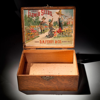

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a wooden box with a painting on it.
==> Ground truth answer: This exhibit features an antique seed box from the late 19th century, specifically from the renowned D.M. Ferry & Co., and is part of the Smithsonian's celebration of National Garden Month. In the 1800s, seed packets were commonly stored in decorative wooden boxes that showcased vibrant labels from seed companies, serving as effective marketing tools on general store counters. This particular seed box, which showcases the D.M. Ferry & Co. label, is significant for its association with the invention of the “commission box,” a display rack that revolutionized retail presentation. Acquired by the Smithsonian in 1986, this artifact highlights the 

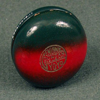

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A red and black item is marked with the word YoYo and the name YoYo.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights the captivating story of the yo-yo, a toy that gained immense popularity in America thanks to Chicago businessman Donald F. Duncan Sr. In 1928, Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant. Flores had begun manufacturing the toy, which he named “yo-yo,” meaning “come-come” in Tagalog. By early 1929, he had established his own company and produced over 100,000 wooden yo-yos, recognizing the need for demonstrations to attract buyers. Duncan, an astute entre

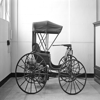

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a black and white image. In this image we can see a vehicle on the floor. In the background we can see a wall and a window.
==> Ground truth answer: The exhibit features the 1893-94 Duryea automobile, recognized as one of the earliest American-made vehicles. On September 21, 1893, Frank Duryea conducted a road test of this innovative automobile, which was essentially a second-hand carriage outfitted with a gasoline engine, in Springfield, Massachusetts. In 1896, Frank and his brother Charles, along with financial partners, established the Duryea Motor Wagon Company, marking it as the first American enterprise to manufacture and sell automobiles. This particular model is powered by a one-cylinder, four-c

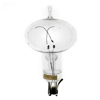

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a bulb.
==> Ground truth answer: This exhibit showcases the Edison Light Bulb, which dates back to 1879 and represents a pivotal moment in the history of innovation. Thomas Edison utilized this carbon-filament bulb during the inaugural public demonstration of his groundbreaking invention—the light bulb, recognized as the first viable electric incandescent lamp. The mechanism of the bulb involves an electrical current flowing through a metal filament wire, which heats up to an intense temperature, ultimately producing light. To safeguard the hot filament from oxygen, the bulb is encased in glass filled with inert gas. This significant demonstration took place at Edison's laboratory in Menlo Park, New Jer

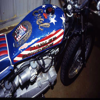

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A harley davidson motorcycle with an american flag paint job.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History showcases Evel Knievel's iconic 1972 Harley-Davidson XR-750, a motorcycle synonymous with the legendary daredevil's thrilling performances. Evel Knievel, born Robert Craig Knievel, captivated audiences with his death-defying stunts, which often resulted in numerous injuries, including 35 to 40 broken bones throughout his career. His televised daredevil shows, beginning in 1965, featured spectacular jumps over rows of vehicles, including cars, trucks, and buses. The XR-750, constructed from steel, aluminum, and fiberglass, weighs around 300 pounds and was pi

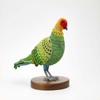

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a toy of a bird.
==> Ground truth answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece cleverly employs humor to highlight the grave issue of species extinction. Through her “Biodiversity Reclamation Suits,” Hope enables common rock pigeons to don the guise of extinct North American birds, symbolically addressing the loss of biodiversity. Utilizing traditional crafting techniques such as carving, embroidery, crochet, and collage, she transforms everyday materials into striking animal sculptures that evoke both playfulness and a deeper emotional response. 

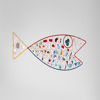

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting of a fish.
==> Ground truth answer: This exhibit features "Fish," a captivating work by renowned artist Alexander Calder, created in 1945 and housed at the Hirshhorn Museum and Sculpture Garden in Washington, D.C. Calder, who was born into a family of artists and initially trained as a mechanical engineer, transitioned to art after working as a freelance illustrator. His journey took him to Paris, where he became inspired by avant-garde movements and began crafting his signature wire sculptures, often referred to as “drawings in space.” Influenced by the minimalist aesthetic of Piet Mondrian, Calder pioneered the concept of “mobiles” in 1931—kinetic sculptures that move with air currents. He 

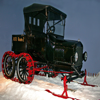

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a vehicle on the snow.
==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a 1921 Ford Model T equipped with a unique snow attachment, highlighting the ingenuity of early 20th-century rural mail carriers. As these carriers transitioned from horse-drawn sleds to automobiles, they faced challenges navigating deep snow. In response, Virgil White innovated by converting cars into snowmobiles, replacing front tires with skis and rear tires with caterpillar treads. His invention, dubbed the Snowbird, provided a cost-effective solution for winter deliveries, eliminating the need for horses. Initially, White's prototype was based on a Buick Model G, but as the Ford Model 

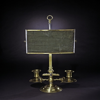

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image I can see a stand and on it I can see two candles. I can also see this image is little bit in dark.
==> Ground truth answer: This exhibit showcases a significant artifact linked to George Washington, specifically a brass candle stand believed to have been used by him while composing his Farewell Address in 1796. After serving two terms as president, Washington chose to retire to Mount Vernon, where he penned his final thoughts for the nation, urging unity among Americans amidst emerging political factions. His Farewell Address was first published in The American Daily Advertiser and has since been commemorated annually by the United States Senate, where a member reads it aloud in honor of Washingt

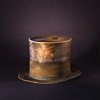

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a hat.
==> Ground truth answer: This exhibit features President Abraham Lincoln's iconic top hat, housed at the Smithsonian's National Museum of American History. Acquired from Washington hat maker J.Y. Davis, this hat stands as a symbol of Lincoln's stature, both physically at 6'4” and in his leadership. Notably, a black silk mourning band adorns the hat, honoring the memory of his son Willie, who passed away in 1862. While the exact date of acquisition remains unknown, the hat was last worn by Lincoln on the fateful night of April 14, 1865, as he headed to Ford's Theatre. Following Lincoln's assassination, the War Department safeguarded the hat along with other belongings left behind, later transferri

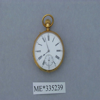

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A pocket watch with roman numerals is displayed above a label that says ME*335239.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History features a remarkable timepiece belonging to Helen Keller, who was born on June 27, 1880. Keller, a pivotal figure in advocating for women's suffrage and workers' rights, faced significant challenges after losing her sight and hearing due to illness at a young age. Her breakthrough came with the help of Anne Sullivan, who taught her to communicate. The Swiss-made "touch watch," gifted to Keller by John Hitz in 1892, is designed with pins around its edge to indicate the hours, allowing Keller to tell time even in darkness. This unique wa

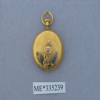

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A gold watch is on display above a label that says ME*335239.
==> Ground truth answer: This exhibit showcases an extraordinary pocket watch that once belonged to Helen Keller, who was born on June 27, 1880. Keller, known for her advocacy for women's rights and disability rights, faced immense challenges after becoming deaf and blind at a young age. Her life changed dramatically when she met Anne Sullivan, who taught her to communicate. The watch, presented to Keller by John Hitz in 1892, features a unique design with pins around the case that allow the wearer to feel the time, making it particularly suitable for someone who could not see. Keller cherished this watch throughout her life, even

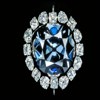

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a diamond pendant.
==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasing a primary gem that weighs an impressive 45.52 carats. The diamond, characterized by its dark gray-blue hue, is cut in a modified antique cushion style, which enhances its unique visual appeal. Originating from India, this exquisite piece is part of the Mineral Sciences collection, specifically within the Gems category at the National Museum of Natural History. The necklace is cataloged under the USNM number NMNH G3551-00 and is a singular specimen in this exhibit, last modified on September 26, 2022. For more detailed information, you can access the original record through t

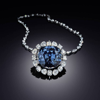

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This necklace contains the largest blue diamond in the world.
==> Ground truth answer: This exhibit showcases a remarkable diamond necklace by Cartier, Inc., featuring a single primary gem that weighs 45.52 carats. The diamond is distinguished by its dark gray-blue color and is elegantly cut in a modified antique cushion shape, which adds to its vintage charm. Sourced from India, this necklace is a highlight of the Mineral Sciences collection at the National Museum of Natural History, categorized under Gems. The record for this exquisite piece is identified as NMNH G3551-00 and was last updated on September 26, 2022. For further details, you can explore the original record linked here.
==> S

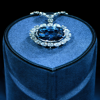

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a necklace on the blue color cloth.
==> Ground truth answer: On display is a captivating diamond necklace by Cartier, Inc., featuring a single, striking primary gem that weighs 45.52 carats. This diamond exhibits a dark gray-blue coloration and is expertly cut in a modified antique cushion style, making it a true work of art. The necklace hails from India and is part of the Mineral Sciences department's Gems collection at the National Museum of Natural History. It is cataloged under the USNM number NMNH G3551-00, with the last modification recorded on September 26, 2022. For more in-depth information, you can follow the link to the o

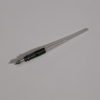

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a pen.
==> Ground truth answer: This exhibit features an Esterbrook pen that holds significant historical importance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2 of that year. Part of the Smithsonian's National Museum of African American History and Culture collection, this particular pen was among over 70 identical pens distributed to key figures in the Civil Rights Movement. The journey to the enactment of this landmark legislation was fraught with challenges, initially introduced by President John F. Kennedy before his tragic assassination in November 1963. The bill's fate then rested with President Johnson, who oversaw lengthy public hearings and debat

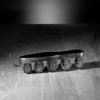

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a toy on the surface.
==> Ground truth answer: This exhibit features the Volito, an innovative inline skate crafted in 1823 by Robert John Tyers. As athletes prepare for the 2014 Winter Olympics, it's intriguing to consider how skaters of the 19th century maintained their skills without the luxury of indoor rinks. The Volito is distinguished by its wooden sole, a single row of five wooden wheels, and a unique curved iron bar at the front, which functioned as a basic brake. What truly set this skate apart was its unequal wheel sizes—larger in the center and smaller at the ends—allowing skaters to navigate turns with greater ease. This remarkable design reflects the ingenuity of early spo

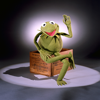

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a toy of a frog. This toy is placed on a box.
==> Ground truth answer: This exhibit showcases Kermit the Frog, a beloved character created by Jim Henson, who has become an iconic figure in children's television. Kermit, a vibrant green puppet, first appeared in 1955 on the show "Sam and Friends" and has since been the star of "The Muppet Show" and a regular on "Sesame Street." Known for his calm demeanor amidst chaos, Kermit is famous for his poignant song “Bein' Green,” which reflects on the challenges of his color while ultimately celebrating his identity. The puppet is crafted from various materials, including synthetic fiber, felt, and plastic, and measures approximately 27 inches in height. This pi

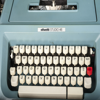

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A blue, Olivetti Studio 46, typewriter with a single red key.
==> Ground truth answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), a celebrated author in the realm of science fiction. Butler is renowned for her impactful works, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the thought-provoking novels Parable of the Sower and Parable of the Talents, along with her acclaimed short story collection, Bloodchild and Other Stories. Her writing uniquely blended elements of African American history with speculative futures and alien psychology, establishing a genre known as Afrofuturism. By centering characters 

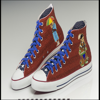

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: These are the shoes which are in red color.
==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The artwork, which takes the form of sneakers, is a unique blend of traditional and contemporary materials, incorporating cotton canvas, glass beads, and commercial rubber. Measuring 33 x 11 x 15 cm, this piece exemplifies Greeves' innovative approach, showcasing overlay beadwork that reflects the rich cultural heritage of the Kiowa people. Acquired by the National Museum of the American Indian from Thirteen Moons Gallery in Santa Fe, New Mexico, this work is part of a broader collection that highlights the intersection of indigenous a

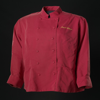

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a red color coat.
==> Ground truth answer: This exhibit showcases a significant collection from the Smithsonian's National Museum of African American History and Culture, featuring a gift from Dooky Chase's Restaurant and renowned Chef Leah Chase. Celebrated for her assertion that “we changed the world over a bowl of gumbo,” Chase played a pivotal role in the civil rights movement by hosting strategy meetings at her restaurant. Known as "The Queen of Creole Cuisine," she elevated New Orleans Creole cooking to global prominence. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop established by her mother-in-law in the 1940s into an elegant dining venue ado

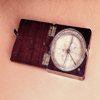

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a compass.
==> Ground truth answer: This exhibit showcases a remarkable silver-plated pocket compass that dates back to around 1804, purchased by Meriwether Lewis in preparation for the historic Lewis and Clark Expedition. Crafted by Philadelphia instrument maker Thomas Whitney, the compass features a mahogany box, a brass rim graduated in degrees, a paper dial, and two brass sight vanes, all housed in a leather carrying case. While it remains uncertain whether Lewis intended the compass for himself or as a gift for his expedition partner, William Clark, it served as a vital navigational tool during their journey. Under President Thomas Jefferson's directive, the Corps of Discovery embarked on their mis

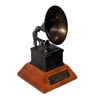

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a trophy.
==> Ground truth answer: This exhibit showcases Bob Newhart's 1960 Grammy Award, a significant artifact from the celebrated comedian's illustrious career. Born on September 5, 1929, in Oak Park, Illinois, Newhart has entertained audiences for over sixty years with his signature deadpan style, cleverly critiquing social norms and the absurdities of American life. His groundbreaking comedy album, The Button-Down Mind of Bob Newhart, made history by becoming the first comedy LP to reach No. 1 on the Billboard charts and won him a Grammy for Album of the Year, making him the only comedian to win a Grammy for Best New Artist. Newhart's influence extended into television, where he starred in iconic 

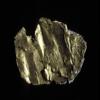

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a gold leaf.
==> Ground truth answer: This exhibit features a remarkable gold nugget from 1848, housed at the Smithsonian's National Museum of American History. Regarded as the first gold piece discovered at Sutter's Mill in California, this nugget played a pivotal role in sparking the infamous gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall noticed a glimmer in the water and retrieved what he identified as a thin scale of pure gold. Following this discovery, Marshall presented the scale to Capt. Joseph L. Folsom, who documented it as the first gold found in Northern California. By August of that year, this nugget, along with other samples, reached Washingt

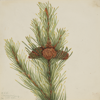

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this painting, we can see a plant with some fruits.
==> Ground truth answer: This exhibit showcases the exquisite watercolor work of Mary Vaux Walcott, particularly her piece titled "Lodgepole Pine (Pinus Contorta murrayana)" created in 1921. Measuring 10 x 7 inches, this artwork is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist encouraged her to paint a rare blooming arnica. Her marriage to Charles Doolittle Walcott, the Smithsonian's Secretary, in 1914 led to summers spent in the Canadian Rockies, where she produced hundreds of watercolor studies of local flora. From 1925 to 1929

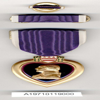

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A Purple Heart is shown with a bronze star and a blue ribbon.
==> Ground truth answer: This exhibit features the esteemed United States Purple Heart, a distinguished military decoration awarded to those wounded or killed while serving in the U.S. armed forces. The medal is crafted in a striking gold heart shape, showcasing a profile relief of George Washington at its center, set against a rich purple enamel background. Above Washington's bust, the medal is adorned with a shield displaying his family coat of arms. The reverse side bears the embossed inscription "FOR MILITARY MERIT," highlighting the medal's significance. It is suspended from a silk purple ribbon, edged with a white stripe, adding to its elegance

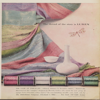

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a poster. On the poster there is a cloth. Also there is a vase. And there are threads. Also there is some text.
==> Ground truth answer: This exhibit, titled "The Thread of the Story Is Lurex: The Look of Porcelain," showcases the work of renowned American textile designer Dorothy Liebes, who significantly influenced various design disciplines from the 1930s to the 1960s. Known for her vibrant colors and rich textures, Liebes developed a distinctive style that became synonymous with the modern American aesthetic, referred to as the “Liebes Look.” Her collaborations with notable architects and designers, such as Frank Lloyd Wright and Raymond Loewy, as well as fashion icons like Pauline 

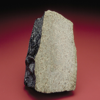

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a large rock that is textured and colored unevenly.
==> Ground truth answer: This exhibit features a fragment of the Nakhla meteorite, which is significant as one of the thirty-four meteorites believed to have originated from Mars. The Nakhla meteorite fell to Earth on June 28, 1911, around 9 a.m. in Alexandria, Egypt, where it was observed exploding in the atmosphere before landing in approximately 40 pieces, weighing a total of 22 pounds. These fragments were found buried up to a meter deep in the ground. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a 480-gram piece to its collection, totaling 650 grams of Nakhla fragments by the 1970s. The Nakhlites, named after 

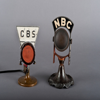

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: Two old fashioned microphones with one saying CBS and one saying NBC.
==> Ground truth answer: This exhibit features a significant artifact from the era of President Franklin D. Roosevelt's "Fireside Chats," a series of informal radio addresses he delivered to the American public starting on March 12, 1933. With the nation grappling with the Great Depression, Roosevelt's ability to communicate directly with citizens through radio became a vital tool for shaping public opinion and providing reassurance. The exhibit highlights an RCA Type 50-A microphone, adorned with the National Broadcasting Company logos, which was used during these broadcasts. Acquired by the museum in 1996, this microphone was preserved by C

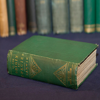

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A green book with gold lettering sits in front of many other books.
==> Ground truth answer: This exhibit showcases "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, anniversary of the HMS Beagle's launch, the vessel that carried Darwin on his pivotal scientific journey. The Beagle was launched from the Woolwich Dockyard in London and underwent several adaptations before embarking on its second survey voyage on December 27, 1831. Darwin, a young naturalist, joined the crew to provide geological insights, and his extensive research during the five-year expedition to South America and the Galápagos Is

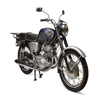

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a motor bike.
==> Ground truth answer: This exhibit features Robert M. Pirsig's iconic 1966 Honda Super Hawk motorcycle, prominently showcased at the Smithsonian's National Museum of American History. This motorcycle is not just a vehicle; it is a symbol of the philosophical journey outlined in Pirsig's influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book quickly became a bestseller, selling over a million copies within its first year and igniting a cultural movement that encouraged individuals to reevaluate their relationship with technology and seek a harmonious existence. The inspiration for "Zen" arose from a transformative r

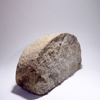

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a rock.
==> Ground truth answer: The exhibit features the Plymouth Rock Piece, a significant artifact housed at the National Museum of American History, which is believed to be linked to the landing of the Mayflower Pilgrims in 1620. According to tradition, this rock marks the site where William Bradford and his fellow settlers first arrived in Plymouth, Massachusetts. Bradford, who played a pivotal role as a leader and governor of the Plymouth Colony, is also credited with the establishment of Thanksgiving as it is celebrated in the United States today. The rock has a storied past, having been relocated in 1774 from its original position to the town square, where it unfortunately split into two halves.

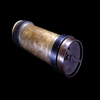

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image I can see a cylindrical object which is in brown and black color.
==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a Pneumatic Mail Container from 1953, a fascinating relic of a bygone era when cities utilized pneumatic tube systems for mail delivery. Originating in the late 1890s, these systems were ingeniously designed to transport mail through underground tubes, with each canister capable of holding up to 500 letters. The canisters, or carriers, were propelled by compressed air, allowing them to travel at speeds averaging 35 miles per hour. At the height of their operation, these systems facilitated the movement of an astounding 6 million pieces of mai

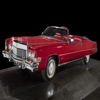

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a car on the floor.
==> Ground truth answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture showcases a remarkable piece of musical history: Chuck Berry's striking red 1973 Cadillac Eldorado. This vehicle is prominently featured in the museum's "Musical Crossroads" exhibition. The Cadillac was a cherished part of Berry's personal collection and gained fame during the filming of the 1987 documentary "Hail! Hail! Rock 'n' Roll," directed by Taylor Hackford. The film captures the essence of two concerts held in 1986 to honor Berry's 60th birthday, and it features a memorable moment when Berry drove this very Cadillac onto the s

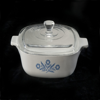

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: White pot with a blue flower design by pyrex.
==> Ground truth answer: This exhibit features a quintessential kitchen item often associated with holiday gatherings—a white casserole dish made by CorningWare in 1965. Adorned with the iconic blue cornflower motif, this dish represents a blend of innovation and tradition. Originally created for military use during World War II, CorningWare's Pyroceram material later emerged as an ideal choice for bakeware, thanks to its ability to endure rapid temperature shifts and resist stains and odors. Its versatility allowed it to transition seamlessly from cooking to freezing to serving, making it a beloved tool in many kitchens. In the 1990s, the brand 

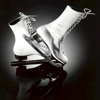

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a pair of skates on the surface.
==> Ground truth answer: This exhibit features the autographed ice skates of Sonja Henie, a pioneering figure in women's figure skating, dating back to around 1945. Henie, a Norwegian skater, revolutionized the sport in the late 1920s and 1930s by introducing white leather skates, a significant departure from the traditional black skates. Her enchanting performances earned her the first of ten consecutive world titles in 1927, where she captivated audiences with her innovative dance style. Henie's influence extended beyond the rink; she was the first to blend choreography with figure skating and popularized the short skirt and white skate aesthetic that 

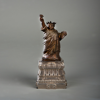

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a statue of liberty.
==> Ground truth answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Crafted in the United States, this statuette was produced in large quantities, with tens of thousands sold to raise funds for the construction of the statue's pedestal in New York Harbor. The design, created by French sculptor Frédéric-Auguste Bartholdi, was made available in both six-inch and twelve-inch sizes, with a national newspaper campaign promoting them at one dollar and five dollars respectively. Richard Butler, a rubber manufacturer from New York, led the American Committee overseeing the production of these models. This ini

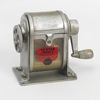

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a machine.
==> Ground truth answer: The exhibit features the Dexter Model 3 Pencil Sharpener, crafted around 1920 by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. This charming artifact, made from metal, cellulose, and painted wood, measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). A gift from Lucy Commoner, it holds a significant place in the Cooper Hewitt, Smithsonian Design Museum collection, although it is not currently on display. As the back-to-school season approaches, this sharpener evokes nostalgia for many, reminiscent of countless school days. The Dexter Model 3 was an evolution of earlier designs, featuring a rotating wheel with calibrated 

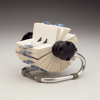

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A round item with cards on it including one that says CARD FILE.
==> Ground truth answer: This exhibit features the iconic Rolodex Open Rotary Card File, a quintessential office supply that revolutionized the way people organized their business contacts before the advent of digital technology. Manufactured by the Rolodex Corporation in the USA, this particular model is crafted from bent tubular metal, molded plastic, rubber, and paper, measuring 18 x 18 x 16.5 cm. The Rolodex operates on a cylindrical design, allowing users to easily flip through A-Z index cards to find contact information. Despite the rise of smartphones and computers, the Rolodex remains a relevant tool in modern workplace

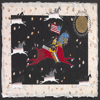

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a painting.
==> Ground truth answer: The exhibit features the "Lakota Horse Mask," created in 2008 by Jim Yellowhawk, a member of the Cheyenne River Lakota tribe. This striking piece, which utilizes acrylic on paper and gold leaf, symbolizes the profound relationship between American Indians and horses, which many tribes refer to as the Horse Nation. Horses were not only allies in times of peace but also played a vital role during conflicts, deeply influencing the cultural landscape of various tribes. Interestingly, horses first emerged in the Americas over 40 million years ago, later becoming extinct before being reintroduced by Columbus in 1493. Today, this artwork is part of the coll

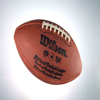

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a football.
==> Ground truth answer: This exhibit features the iconic Wilson Duke football, which has been the official ball of the Super Bowl since Super Bowl II in 1968. The football on display was specifically used during Super Bowl XIV, held at the Rose Bowl in Pasadena, California, on January 20, 1980. In this thrilling game, the Pittsburgh Steelers triumphed over the Los Angeles Rams with a score of 31-19, marking the Steelers' fourth Super Bowl victory. Notably, it was also the second consecutive year that quarterback Terry Bradshaw earned the Most Valuable Player award. The Wilson Duke football, known for its premium leather and durable construction, was introduced by Wilson Spo

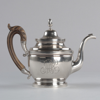

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a silver teapot with a monogram of AH engraved on it.
==> Ground truth answer: This exhibit features a remarkable silver teapot created by American artisan Peter Bentzon, dating from approximately 1817 to 1829. The teapot showcases an elegant oval vase shape, supported by a spreading pedestal foot. Its design includes a gracefully curved spout, which is topped with an incised patera, and a scroll handle adorned with wooden leaf caps. The hinged domed lid is finished with an acorn finial, adding to its aesthetic appeal. Notably, the piece bears the scripted monogram "MC" engraved on its side, alongside the name "Rebecca Dawson" inscribed along the bottom rim. This exquisite object is part of the National

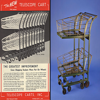

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a poster. On the left side there is a trolley. On the right side there is a poster.
==> Ground truth answer: The exhibit at the National Museum of American History features the innovative Telescoping Shopping Cart, designed by Orla E. Watson in 1946. This clever invention, first introduced in 1947 at Floyd's Super Market in Kansas City, Missouri, revolutionized the way consumers shop by allowing carts to nest together for efficient storage. Watson asserted that these new carts utilized only one-fifth of the space of traditional carts when parked, making them a practical solution for busy shoppers. This display is part of the Smithsonian's inaugural major exhibition on food history, which delves into the

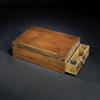

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a wooden box with two drawers.
==> Ground truth answer: This exhibit showcases the portable writing desk designed by Thomas Jefferson, which he used to draft the Declaration of Independence in 1776. The desk features a hinged writing board and a locking drawer for storing essential writing materials such as papers, pens, and an inkwell. During the summer of 1776, as members of the Second Continental Congress prepared to declare independence from Great Britain, Jefferson, a Virginia delegate, was tasked with drafting this pivotal document. He later noted that the declaration was meant to reflect the collective American sentiment rather than being an original work. On July 4, 1776, the Continental Congres

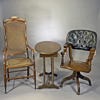

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: There are three chairs. The one on the left has a high back and is padded. The one in the middle has a round table. The one on the right has a high back and a round table.
==> Ground truth answer: This exhibit focuses on a pivotal moment in American history, specifically the surrender of the Confederate Army at Appomattox Court House on April 9, 1865. It showcases the chair used by General Ulysses S. Grant during his negotiations with General Robert E. Lee, marking the effective conclusion of the Civil War. The exhibit highlights how Grant, seated in this chair, drafted and signed the surrender terms, a significant act that symbolized the end of hostilities. Following the surrender, Union officers took pieces o

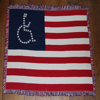

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: On the floor is a blanket with the American flag on it.
==> Ground truth answer: This exhibit features a unique lap blanket that has been hand-altered to incorporate the universal access symbol, represented by stitched stars, reflecting the ideals of freedom and independence associated with the American flag. Created by advocates from the American Disabled for Attendant Programs Today (ADAPT), this piece signifies the ongoing struggle for civil rights among individuals with disabilities. Founded in 1983 in Denver, ADAPT emerged from the disability rights movement, which gained momentum after World War II as individuals with disabilities formed communities and advocated for their rights. The lap blanket serves a

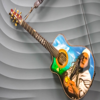

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A guitar is against a wall with the word Vive painted on it.
==> Ground truth answer: This exhibit showcases the guitar of Carlos Vives, a renowned Colombian singer and Grammy Award winner celebrated for his contributions to the vallenato music genre. Vallenato, originating from Colombia's Atlantic coast, blends European instruments like the accordion with rich, poetic lyrics and the traditional rhythms of the Arhuaco indigenous people. Historically, vallenato was performed by rural workers and cowboys, remaining largely within local communities until its revitalization in the 1990s by artists like Vives, who infused it with pop and rock elements. This transformation propelled vallenato into the global spotligh

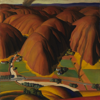

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this image we can see hills, trees, houses, road, grass and sky.
==> Ground truth answer: This exhibition features a captivating painting by Ross Dickinson, a talented artist who thrived during the Great Depression. Created while he was part of the Public Works of Art Project, the artwork vividly portrays California's Central Valley, showcasing lush green fields alongside a small river, all framed by stark, arid hills. The scene evokes the promised land sought by many families fleeing the Dust Bowl, yet Dickinson introduces an unsettling element—a small controlled fire in the foreground and a larger plume of smoke rising from the distant hills, hinting at the ever-present threat of wildfi

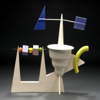

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a sculpture.
==> Ground truth answer: This exhibit features the imaginative work of artist Peter Shire, born in Los Angeles in 1947. Notably, Shire's teapots, particularly the Weathervane Teapot, are vibrant constructions made from clay slabs, showcasing a playful arrangement of three-dimensional squares, balls, squiggly rods, and hollow tubes. Shire aimed to challenge conventional notions of "tea-time," making it an experience that is inclusive and accessible to everyone. The design of this teapot invites interaction, prompting viewers to ponder how to hold it for pouring, or whether it is even functional as a teapot. After 1985, Shire shifted his focus from creating clay teapots to furniture design. A

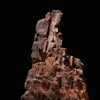

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a wooden object.
==> Ground truth answer: The exhibit features the Spotsylvania tree stump, a poignant relic from the Civil War, dating back to 1864–65, located at the Smithsonian's National Museum of American History. This tree, once a majestic oak, stood in a serene meadow near Spotsylvania Court House, Virginia, until May 12, 1864, when it became a silent witness to the brutal conflict between Confederate forces and the Union's Second Corps. The area, now known as the Bloody Angle, transformed dramatically over the course of a single day, as the fierce combat led to approximately 31,000 casualties. The tree stump bears the scars of war, with several Minié balls still lodged within it

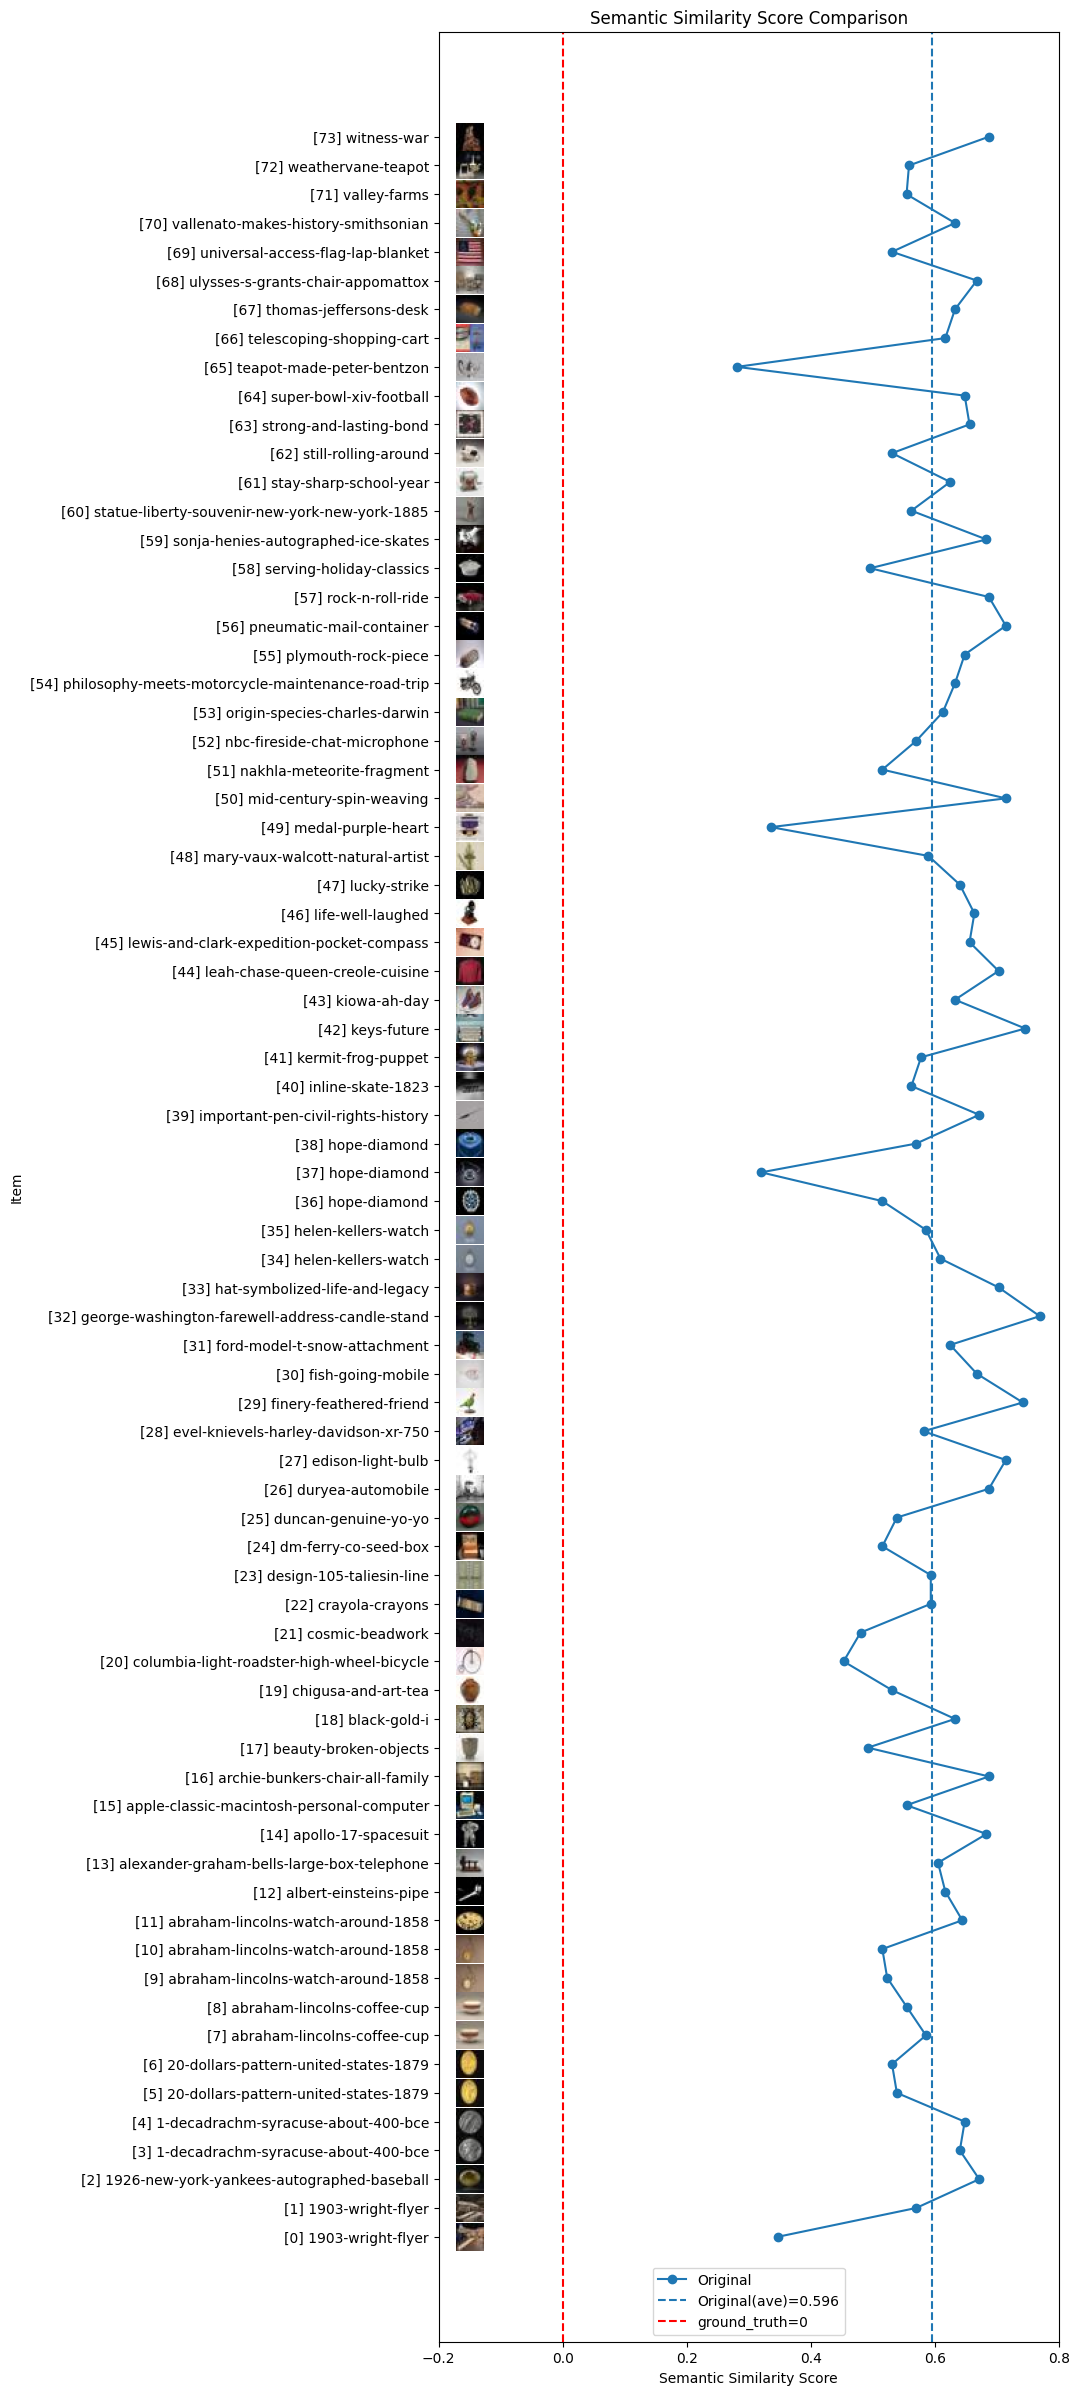

In [10]:
importlib.reload(my_utils)

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(base_model, processor, dataset['test'], './results/inference_results/inference_results_before_finetuning.csv', 14) 

# Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv')], 
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_before_finetuning.jpg')


---
# **Step 3: Training**

## 3.1 Add a Custom Padding Token

In [11]:
%%writefile -a my_utils.py

#--------------- Set Up Pad Token ---------------
# 1) Set up pad token in processor
def setup_pad_token_in_processor(processor, pad_token='<pad>'):
    print(f'==> Setting up pad token (<pad>) in processor...')
    print(f'==> [Original] Regular token count: {processor.tokenizer.vocab_size}, regular + special token count: {len(processor.tokenizer)}, pad token in tokenizer: {processor.tokenizer.pad_token}')
    if pad_token not in processor.tokenizer.get_vocab():
        print(f'==> Adding new pad token: {pad_token}')
        processor.tokenizer.add_special_tokens({'pad_token': pad_token})
    processor.tokenizer.pad_token = pad_token
    processor.tokenizer.padding_side = 'left'     # Flash Attention version of the Mistral model requires left padding
    print(f'==> [Updated] Regular token count: {processor.tokenizer.vocab_size}, regular + special token count: {len(processor.tokenizer)}, pad token in tokenizer: {processor.tokenizer.pad_token}')

# 2) Set up pad token in model
def setup_pad_token_in_model(model, processor):
    print(f'==> Setting up pad token (<pad>) in model...')
    print(f'==> Configuring pad token in model.config and model.model.text_model for input sequence padding...')
    pad_token_id = processor.tokenizer.pad_token_id 
    model.config.pad_token_id = pad_token_id
    model.config.perceiver_config.pad_token_id = pad_token_id
    model.config.text_config.pad_token_id = pad_token_id
    model.config.vision_config.pad_token_id = pad_token_id
    model.model.text_model.embed_tokens.padding_idx = pad_token_id
    print(f'==> Configuring pad token in model.generation_config for output sequence padding...')
    model.generation_config.pad_token_id = pad_token_id
    print(f'==> Checking if resizing of model embeddings is needed...')
    current_embedding_size = model.get_input_embeddings().num_embeddings
    if current_embedding_size != len(processor.tokenizer):
        new_embedding_size = len(processor.tokenizer)
        model.resize_token_embeddings(new_embedding_size)
        print(f'==> Resized model embeddings from {current_embedding_size} to {new_embedding_size}.')
    else:
        print(f'==> No resizing needed for token embeddings.')

Appending to my_utils.py


In [12]:
importlib.reload(my_utils)
# Set up pad token (<pad>) in the processor
my_utils.setup_pad_token_in_processor(processor)
# Set up pad token (<pad>) in the base model
my_utils.setup_pad_token_in_model(base_model, processor)


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.


## 3.2 Create a LoRA Adapter

### **Tunable Layers:**

The base model is structured into three main modules: `vision_model`, `text_model`, and `connector`. For this project, the focus is on enhancing the model's ability to interpret and respond to exhibition images with historical and contextual insights, rather than capturing fine-grained image details (as would be required in applications like medical image diagnosis). Therefore, we will freeze the `vision_model` module and only fine-tune the `text_model` and `connector` modules.  

When fine-tuning, it's common practice to freeze the `embedding`, `normalization`, and `lm_head` layers. This approach helps maintain the model's foundational language capabilities, enhances stability, and reduces overfitting. Here, we will apply LoRA adapters specifically to the `linear` layers within the `text_model` and `connector` modules to refine the model's task-specific understanding.

### **LoRA Rank (`r`):**

In our experiments, values of `r = 8`, `16`, `32`, and `64` yielded comparable results. We choose `r = 8` as our LoRA rank because a smaller rank reduces the number of trainable parameters, leading to lower VRAM consumption while achieving similar performance.

### **Trainable Parameters:**

By selecting specific tunable layers and an optimal LoRA rank as shown above, the number of trainable parameters for LoRA fine-tuning is only `0.28%` of the total model parameters.

### **LoRA Alpha:**

When using Rank-Stabilized LoRA (RS-LoRA), the rule of thumb for setting lora_alpha is to scale it based on the square root of the model dimension (dm). Specifically, lora_alpha is often set as: `lora_alpha = sqrt(dm)`, where `dm` is the module dimension.  

Since our model's text module dimension (dm) is `4096` (retrieved from `base_model.config.text_config.hidden_size`), we calculate: `lora_alpha = sqrt(dm) = sqrt(4096) = 64`. This setup helps achieve a balanced scaling for stable and effective fine-tuning.  

In [13]:
%%writefile -a my_utils.py

#--------------- LoRA Adapter ---------------
# 1) Create a LoRA adapter
# !pip install peft==0.13.0 -q -U
from peft import LoraConfig, get_peft_model
def create_lora_adapter(base_model, r, lora_alpha):
    print(f'==> Creating LoRA adapter...')
    peft_config = LoraConfig( 
        # Define 'target_modules' to select linear layers in 'text_model' and 'connector' modules for fine-tuning
        # Example regex usage link: https://github.com/huggingface/peft/blob/v0.12.0/src/peft/tuners/lora/config.py#L162
        target_modules= '.*(text_model|connector).*(q_proj|k_proj|v_proj|o_proj|gate_proj|up_proj|down_proj).*$',  
        r=r,                                      # LoRA rank
        lora_alpha=lora_alpha,                    # LoRA scaling factor        
        bias="none",                              # Typically in LoRA, we fine-tune weights, not biases
        lora_dropout=0.1,                         # Dropout to help prevent overfitting
        task_type="CAUSAL_LM",                    # Set for causal language modeling tasks
        init_lora_weights="gaussian",             # Initialize LoRA A matrix with Gaussian values; LoRA B matrix with zeros
        use_rslora=True,                          # Use Rank-Stabilized LoRA for stability
    )
    lora_model = get_peft_model(base_model, peft_config)   
    return lora_model

# 2) Load LoRA adapter from a checkpoint and set LoRA to trainable state
from peft import PeftModel
def load_lora_adapter_from_checkpoint(base_model, lora_checkpoint):
    # Setting 'is_trainable=True' puts LoRA in a trainable state
    # Source: https://discuss.huggingface.co/t/correct-way-to-save-load-adapters-and-checkpoints-in-peft/77836/2
    print(f'==> Loading LoRA adapter from checkpoint...')
    lora_model = PeftModel.from_pretrained(base_model, lora_checkpoint, is_trainable=True)
    return lora_model


Appending to my_utils.py


In [14]:
importlib.reload(my_utils)    

import math
hidden_size = base_model.config.text_config.hidden_size
print(f'==> Model\'s text module\'s dimension (dm) is: {hidden_size}')
print(f'==> lora_alpha = sqrt(dm) = {int(math.sqrt(hidden_size))}') 

#create lora adapter with rank=8 and lora_alpha=64
lora_model = my_utils.create_lora_adapter(base_model, 8, 64)
my_utils.print_model_info_to_file(lora_model, './results/model_info/lora_model_info.txt')
my_utils.print_model_parameters_to_file(lora_model, './results/model_info/lora_model_parameters.txt')

==> Model's text module's dimension (dm) is: 4096
==> lora_alpha = sqrt(dm) = 64
==> Creating LoRA adapter...
==> Printing model info...
==> Model type: PeftModelForCausalLM
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/lora_model_info.txt.
==> Printing model parameters...
base_model.model.model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.encoder.layers.0.self_attn.k_proj.bias (1152, torch.bfloat16, cuda, False)
base_model.model.model.vision_mod

## 3.3 Set Up the Trainer and (Optional) Perform a Dry Run with a Custom DataCollator

### **Custom DataCollator (collate_fn()):**

To simplify the setup, we don't define a custom `DataLoader` to pass into our trainer. Instead, we define a custom `DataCollator` (using `collate_fn()`) to pass to the trainer. Our Hugging Face trainer will internally create a DataLoader to handle dataset batching. This DataLoader uses a `sampler` to select samples from the dataset and form them into batches. Once samples are selected, our custom `DataCollator` takes over, further processing the data to prepare it for the trainer. Specifically, our custom DataCollator formats data into tensors, pads each batch to a consistent length, and applies masking to exclude specific tokens from loss computation.

- Custom DataCollator design using collate_fn(): [HF: TRL (Transformer Reinforcement Learning) examples](https://github.com/huggingface/trl/blob/main/examples/scripts/sft_vlm.py#L87-L106)  
- Custom DataCollator class example: [HF: Idefics2 - Fine-tuning tutorial](https://colab.research.google.com/drive/1rm3AGquGEYXfeeizE40bbDtcWh5S4Nlq#scrollTo=yePZRNBTK0Ux)  
- Padding guide: [HF: Padding and truncation](https://huggingface.co/docs/transformers/en/pad_truncation)  

  
### **Custom Callback Function (optional):**

Below is the GPU VRAM hierarchy in PyTorch and CUDA:
```text
Total GPU VRAM:
    |-- Available GPU VRAM                               # Free memory that can be allocated.
    |-- Used GPU VRAM                                    # Monitor real-time with 'watch -n 0.5 nvidia-smi'.
         |-- CUDA context, kernel, lib occupied memory   # Fundamental overhead for CUDA operations.
         |-- Temporary memory                            # Used for intermediate computations (e.g., backpropagation); auto-deallocated after operations complete.
         |-- PyTorch reserved memory                     # Managed by PyTorch's caching allocator; query with 'torch.cuda.memory_reserved()'.
                |-- PyTorch allocated memory             # Actively used computing memory (e.g., tensors, parameters); query with 'torch.cuda.memory_allocated()'.
                |-- Reserved for future use              # Memory reserved by PyTorch for future re-allocation, not currently in use. Unavailable to other processes;
                |                                        # can be freed with 'torch.cuda.empty_cache()'.
                |-- Memory fragmentation                 # Unusable memory due to non-contiguous blocks.
```

We define a custom callback function to monitor VRAM usage during training; its use is optional. This function prints both the `current` and `peak` "PyTorch allocated memory" during the first training step.

Please note that "PyTorch allocated memory" represents only the minimum required memory for model training. In practice, during training, all other types of memory mentioned above also occupy GPU VRAM. For more accurate monitoring, use the command `watch -n 0.5 nvidia-smi` in a terminal to observe real-time GPU VRAM usage.


### **Hyperparameters and Settings in Trainer:**

#### Learning Rate

Generally, a small learning rate is chosen at the beginning of experiments. If convergence is slow, the rate can be gradually increased. Conversely, if the loss curve is unstable, the rate may be reduced. In our experiments, we use `1e-5`, which has proven effective for achieving stable convergence.

For stable training, we slowly ramp up the learning rate at the beginning of training by setting `warmup_ratio=0.03`, and gradually reduce the learning rate toward the end of training by setting `lr_scheduler_type="cosine"`.

#### Batch Size

Both training and evaluation batch sizes are constrained by VRAM limitations, with the training batch size typically hitting the VRAM bottleneck first. While training and evaluation batch sizes can differ, for simplicity, we use `the same batch size for both`. To determine the maximum workable training batch size, we start with a small batch size (e.g., 1) and gradually increase it until the GPU's VRAM limit is reached (resulting in an Out of Memory error). Once the maximum stable training batch size is identified, it is used for both training and evaluation to ensure consistency.

#### Gradient Accumulation Steps

Gradient accumulation effectively simulates a larger batch size on GPUs with limited VRAM by accumulating gradients over multiple forward passes before performing a backward update. Large batch sizes generally yield more stable training by averaging gradients over more samples, often resulting in better generalization. However, for this project, with a relatively small dataset, we aim to maximize the model's ability to capture dataset-specific details. Thus, we use a small batch size and set the gradient accumulation step to `1` to allow more updates on limited data during training so the model can memorize specific details. Experiments show that values of `1` or `2` yield the best results, while higher values (e.g., `>=3`) degrade performance.

#### Data Type

By default, models are trained in `fp32` (32-bit, range: ±1.18e-38 ~ ±3.39e38). In our experiments, we use `bf16` (16-bit, range: ±1.18e-38 ~ ±3.39e38), supported by Nvidia Ampere architecture GPUs, which uses half the memory of fp32 while maintaining training stability due to its range. Note that `fp16` (16-bit, range: ±6.55e-5 to ±6.55e4) also halves memory usage but can cause training instability due to its limited range.

#### Gradient Checkpointing

We enable `gradient_checkpointing` during training. This reduces VRAM usage by storing only select gradients but requires additional computation time, as activation values are recalculated during the backward pass. This approach allows training on GPUs with limited VRAM and enables larger batch sizes, accelerating the overall training process.

Please note that gradient checkpointing is enabled only for non-FSDP training. For FSDP training, activation checkpointing is enabled through the `FSDP config`.

#### Used and Unused Columns

`"Used"` columns are the dataset columns that are directly consumed by the model's forward method, such as `input_ids` and `attention_mask`. Other columns (`"Unused"`) are not directly related to the model's forward method but may still be required for data processing in a custom collate_fn, such as `image` and `dialog` columns.

To ensure all necessary columns are available, we retain all columns in the dataset by setting `remove_unused_columns=False`.

#### Step-Based Triggers

`train_steps = (epoch_num * total_samples_in_dataset) / (batch_size * gradient_accumulation_steps)`

We use training steps to trigger evaluation, log metrics, and save model checkpoints. For simplicity, we set 5% of total training steps as an interval to trigger these three activities: `eval_steps=0.05`, `logging_steps=0.05`, and `save_steps=0.05`.



In [15]:
%%writefile -a my_utils.py

#--------------- Trainer ---------------
# 1) Define custom DataCollator (collate_fn()) to process data in a batch
def collate_fn(dataset, processor, inspection_mode=False):
    '''
    Example data formats used in this function are detailed below for reference:
    1. Format of input dataset:
        {
            'image': image0, 
             ...
            'dialog': '{"messages": [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": "aaa"} ]}, 
                                    {"role": "assistant", "content": [{"type": "text", "text": "bbb"} ]}]
                      }'
        }
        {
            'image': image1, 
             ...
            'dialog': '{"messages": [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": "ccc"} ]}, 
                                    {"role": "assistant", "content": [{"type": "text", "text": "ddd"} ]}]
                      }'
        }
    2. Format of texts[]:
        [
            'User:<image>aaa<end_of_utterance>\nAssistant: bbb<end_of_utterance>\n', 
            'User:<image>ccc<end_of_utterance>\nAssistant: ddd<end_of_utterance>\n'
        ]
    3. Format of images[]:
        [
            [<PIL.Image.Image image mode=RGB size=800x800 at 0x17B44EC7D90>], 
            [<PIL.Image.Image image mode=RGB size=800x800 at 0x17B44EC7F10>]
        ]
    4. Format of output batch (right side padding is applied here just for demonstration):
        {
        'input_ids':            tensor([ [texts[0].tensor ............................ + <pad><pad>...<pad>], [texts[1].tensor ............................ + <pad><pad>...<pad>] ]), 
        'labels':               tensor([ [texts[0].tensor(<image> and question masked) + -100 -100 ...-100 ], [texts[1].tensor(<image> and question masked) + -100 -100 ...-100 ] ]), 
        'attention_mask':       tensor([ [1    1    1  ......................  1    1  +   0    0  ...  0  ], [1    1    1  ......................  1    1  +   0    0  ...  0  ] ]), 
        'pixel_values':         tensor([ [images[0].pixels ................................... ],             [images[1].pixels ................................... ]             ]), 
        'pixel_attention_mask': tensor([ [1    1    1  ......................  1    1    1    1],             [1    1    1  ......................  1    1    1    1]             ])
        }
    '''

    # Step 1: Process the data batch by extracting images to images[], extracting and formatting texts to texts[]
    texts = [processor.apply_chat_template(json.loads(data['dialog'])['messages'], add_generation_prompt=False, tokenize=False) for data in dataset]
    images = [[data['image']] for data in dataset]

    # Step 2: Tokenize texts[] and images[] with padding applied
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)   # padding=True pads sequences to the longest in the batch
  
    # Step 3: Create batch["labels"]
    # During training:
    # batch["input_ids"] serves as the model input:       'User:<image>question<end_of_utterance>\nAssistant: answer<end_of_utterance>\n<pad><pad>'
    # batch["labels"] serves as the target output:        'User:xxxxxxxxxxxxxxx<end_of_utterance>\nAssistant: answer<end_of_utterance>\nxxxxxxxxxx'
    # batch["labels"] is identical to batch["input_ids"], but with '<image>' token, 'user question' and '<pad>' token masked (set to -100) to ignore them in loss computation.
    labels = batch['input_ids'].clone()
    fake_token_around_image_token_id = processor.tokenizer.convert_tokens_to_ids('<fake_token_around_image>')  # fake_token_around_image_token_id: 32000
    image_token_id = processor.tokenizer.convert_tokens_to_ids('<image>')                                      # image_token_id: 32001
    end_of_utterance_token_id = processor.tokenizer.convert_tokens_to_ids('<end_of_utterance>')                # end_of_utterance_token_id: 32002
    pad_token_id = processor.tokenizer.pad_token_id                                                            # pad_token_id: 32003
    # Step 3.1: Mask 'user question' section
    for row in labels:
        # Check for exactly two `<end_of_utterance>` tokens; otherwise data format is invalid
        end_of_utterance_token_id_count = torch.sum(row == end_of_utterance_token_id).item()
        if end_of_utterance_token_id_count != 2:
            raise ValueError(f'==> [Error] Expected 2 occurrences of <end_of_utterance> in data, but found {end_of_utterance_token_id_count}.')
        # Mask 'user question' section in the current row
        updating = False
        for i in range(1, len(row)):
            if row[i - 1] == fake_token_around_image_token_id and row[i] != image_token_id:  # 'user question' starts after image section
                updating = True
            elif row[i] == end_of_utterance_token_id:                                        # 'user question' ends at the first <end_of_utterance>
                break
            if updating:
                row[i] = -100 
    # Step 3.2: Mask '<pad>' tokens
    labels[labels == pad_token_id] = -100
    # Step 3.3: Mask '<image>' tokens
    labels[labels == image_token_id] = -100

    batch['labels'] = labels

    if inspection_mode: 
        print(f'==> [custom DataCollator] Format of input dataset: \n{dataset[0]}\n{dataset[1]}')
        print(f'==> [custom DataCollator] Text count in the dataset: {len(texts)}, image count in the dataset: {len(images)}')
        print(f'==> [custom DataCollator] Format of texts[]: \n{texts}')
        print(f'==> [custom DataCollator] Format of images[]: \n{images}')
        print(f'==> [custom DataCollator] Format of output batch[\'input_ids\']: \n{batch["input_ids"]}')
        print(f'==> [custom DataCollator] Format of output batch[\'labels\']: \n{batch["labels"]}')
        print(f'==> [custom DataCollator] Format of output batch[\'attention_mask\']: \n{batch["attention_mask"]}')
        print(f'==> [custom DataCollator] Format of output batch[\'pixel_values\']: \n{batch["pixel_values"]}')
        print(f'==> [custom DataCollator] Format of output batch[\'pixel_attention_mask\']: \n{batch["pixel_attention_mask"]}')

    return batch


Appending to my_utils.py


In [16]:
importlib.reload(my_utils)

print(f'==> (Optional) Processing sample data using custom DataCollator...')
# Select the first 2 rows of the dataset as samples
sample_dataset = dataset['test'].select(list(range(2)))
# Process sample data using custom DataCollator
batch = my_utils.collate_fn(sample_dataset, processor, inspection_mode=True)  # inspection_mode=True: print internal data structures for inspection


==> (Optional) Processing sample data using custom DataCollator...
==> [custom DataCollator] Format of input dataset: 
{'image': <PIL.Image.Image image mode=RGB size=800x800 at 0x7F89544FB850>, 'data_id': 3, 'item_name': '1-decadrachm-syracuse-about-400-bce', 'image_name': '1-decadrachm-syracuse-about-400-bce-1.jpg', 'dialog': '{"messages": [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": "Can you describe this exhibit?"} ]}, {"role": "assistant", "content": [{"type": "text", "text": "The exhibit features the Syracuse dekadrachm, a remarkable coin from antiquity renowned for its exquisite artistry and high relief, crafted by notable designers like Kimon and Euinatos. This coin has captivated enthusiasts for over 2,500 years, raising questions about how the ancient Greeks achieved such beauty using only hand tools. An interesting connection to American history is found in Theodore Roosevelt, who, while known for his political reforms, also sought to enhance Amer

In [17]:
%%writefile -a my_utils.py

# 2) Define a custom callback function to report VRAM usage
from transformers import TrainerCallback
class CustomCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        # Report VRAM usage only if using a GPU and during the first training step
        if torch.cuda.is_available() and state.global_step == 1:
            num_gpus = torch.cuda.device_count()
            for gpu_id in range(num_gpus):
                gpu_memory = torch.cuda.memory_allocated(gpu_id) / (1024 ** 3)
                gpu_max_memory = torch.cuda.max_memory_allocated(gpu_id) / (1024 ** 3)
                total_memory = torch.cuda.get_device_properties(gpu_id).total_memory / (1024 ** 3)
                print(f'[GPU{gpu_id}] Step {state.global_step}: Current VRAM usage: {gpu_memory:.2f} GB, Peak VRAM usage: {gpu_max_memory:.2f} GB, Total GPU VRAM: {total_memory:.2f} GB')

# 3) Set up hyperparameters and other training settings in a Hugging Face Trainer
from transformers import Trainer, TrainingArguments
def setup_trainer(model, processor, dataset, collate_fn, epoch_num, batch_size, callbacks=None, use_fsdp=False):
    print(f'==> Setting up trainer...')
    trainer = Trainer(
        model=model,
        data_collator=lambda batch: collate_fn(batch, processor=processor),              # Use a custom DataCollator
        train_dataset=dataset["train"],                                                  # Training dataset
        eval_dataset=dataset["validation"],                                              # Validation dataset
        callbacks=callbacks,                                                             # Optional: Custom callbacks (e.g., for monitoring and reporting VRAM during training)
        args=TrainingArguments(
            # 1. Hyperparameters                               
            optim="adamw_torch",                                                         # Use the AdamW optimizer
            weight_decay=0.01,                                                           # Apply a 1% penalty on weight magnitude at each training step to reduce overfitting
            max_grad_norm=0.3,                                                           # Clip gradients to stabilize training and avoid large updates
            warmup_ratio=0.03,                                                           # During the first 3% of training steps, linearly increase the learning rate from 0 to the designated value (e.g., 1e-5)
            learning_rate=1e-5,                                                          # For the remaining 97% of steps, the learning rate starts at 1e-5
            lr_scheduler_type="cosine",                                                  # The learning rate then follows a cosine decay schedule, gradually decreasing toward the end of training
            log_level="debug",                                                           # Provide detailed training logs
            bf16=True,                                                                   # Use bf16 to reduce VRAM usage (requires Ampere or newer GPUs); default is fp32
            remove_unused_columns=False,                                                 # Retain all dataset columns, including those not explicitly consumed by the model's forward method.
            gradient_checkpointing=None if use_fsdp else True,                           # FSDP: defer to FSDP config; otherwise, enable gradient checkpointing to reduce VRAM usage by recomputing activations
            gradient_checkpointing_kwargs=None if use_fsdp else {'use_reentrant': True}, # FSDP: defer to FSDP config; otherwise, use reentrant autograd for backward passes

            # 2. Training settings (train_steps = (epoch_num * total_samples_in_dataset) / (batch_size * gradient_accumulation_steps))
            num_train_epochs=epoch_num,                                                  # Total number of epochs
            per_device_train_batch_size=batch_size,                                      # Training batch size per device
            per_device_eval_batch_size=batch_size,                                       # Evaluation batch size per device
            gradient_accumulation_steps=1,                                               # Set to 1 to allow frequent updates when training on limited data

            # 3. Evaluation settings                               
            eval_strategy="steps",                                                       # Perform evaluation periodically based on training steps
            eval_steps=0.05,                                                             # Perform evaluation every 5% of total training steps

            # 4. Logging settings                               
            logging_strategy="steps",                                                    # Log metrics periodically based on training steps
            logging_steps=0.05,                                                          # Log metrics every 5% of total training steps
            logging_dir='./results/tensorboard_logs',                                    # Directory for saving TensorBoard logs
            report_to="all",                                                             # Report metrics to all supported platforms (e.g., TensorBoard, WandB)

            # 5. Model checkpoint settings                               
            save_strategy="steps",                                                       # Save model checkpoints periodically based on training steps
            save_steps=0.05,                                                             # Save model checkpoints every 5% of total training steps
            save_total_limit=20,                                                         # Retain the latest 20 model checkpoints on disk
            output_dir='./results/training_checkpoints',                                 # Directory for saving model checkpoints
        ),
    )
    return trainer

Appending to my_utils.py


In [18]:
importlib.reload(my_utils)

custom_callback = my_utils.CustomCallback()  # Optional: Custom callback to report VRAM usage during the first training step
trainer = my_utils.setup_trainer(lora_model, processor, dataset, my_utils.collate_fn, epoch_num=3, batch_size=14, callbacks=[custom_callback])


==> Setting up trainer...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Using auto half precision backend


## 3.4 Train the Model

In [19]:
%%writefile -a my_utils.py

#--------------- Training ---------------
# 1) Run model training
def run_training(model, trainer):
    print(f'==> Starting training...')
    model.config.use_cache = False  # Disable the model's caching mechanism during training to recompute hidden states from scratch at each step.
    torch.cuda.empty_cache()        # Clear PyTorch cache to maximize VRAM availability for training.
    trainer.train()                 # Start training. Automatically sets the model to training mode (model.train()).
    torch.cuda.empty_cache()        # Clear PyTorch cache again after training to free up VRAM.
    model.config.use_cache = True   # Re-enable the model's caching mechanism to store and reuse hidden states, speeding up inference.


Appending to my_utils.py


In [20]:
importlib.reload(my_utils)

my_utils.run_training(lora_model, trainer)

==> Starting training...


Currently training with a batch size of: 14
***** Running training *****
  Num examples = 819
  Num Epochs = 3
  Instantaneous batch size per device = 14
  Total train batch size (w. parallel, distributed & accumulation) = 14
  Gradient Accumulation steps = 1
  Total optimization steps = 177
  Number of trainable parameters = 23,326,720
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


[GPU0] Step 1: Current VRAM usage: 16.19 GB, Peak VRAM usage: 37.64 GB, Total GPU VRAM: 47.53 GB



***** Running Evaluation *****
  Num examples = 82
  Batch size = 14
Saving model checkpoint to ./results/training_checkpoints/checkpoint-9
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]

***** Running Evaluation *****
  Num examples = 82
  Batch size = 14
Saving model checkpoint to ./results/training_checkpoints/checkpoint-18
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoin

## 3.5 (Optional) Examine the Training Results

### **Custom Callback Function Log:**

The training log above includes VRAM usage reported by our custom callback function during the first training step. For example:  
`[GPU0] Step 1: Current VRAM usage: 16.19 GB, Peak VRAM usage: 37.64 GB, Total GPU VRAM: 47.53 GB`

Note: The VRAM usage reported here refers to "PyTorch allocated memory," which represents only the minimum memory required for model training. However, during training, other memory allocations (e.g., temporary memory, caching) also occupy GPU VRAM. For more accurate monitoring, use the command `watch -n 0.5 nvidia-smi` in a terminal to observe real-time GPU VRAM usage.

### **Weights & Biases Metrics Visualization:**

The training log above also displays a link (e.g., `View run at https://wandb.ai/xugefu/huggingface/runs/xxxxxxxx`) to analyze this run's training metrics through the Weights & Biases metrics dashboard. Below is a sample preview of the wandb dashboard:  

<img src="../assets/wandb.png" height="500" alt="Weights & Biases" style="border: 1px solid #ccc; padding: 5px; display: block;">

### **TensorBoard Metrics Visualization:**

Training metrics can also be visualized using TensorBoard. Below is a sample preview of the TensorBoard:  

<img src="../assets/tensorboard.png" height="400" alt="TensorBoard" style="border: 1px solid #ccc; padding: 5px; display: block;">

To access TensorBoard when running trainings on RunPod ([Discussion Link](https://www.answeroverflow.com/m/1208569554402414602)), follow these steps:

1. Pod Configuration: When starting a new pod, ensure that the pod is configured to `expose HTTP Port 6006` (TensorBoard uses this port).  
2. Install TensorBoard: The TensorBoard Python package is installed during step 1.1 of this notebook.  
3. Start TensorBoard:  
   - In the Pod Dashboard: Navigate to `Connect -> Start Web Terminal -> Connect to Web Terminal`.  
   - In the Web Terminal, execute command: `tensorboard --logdir /workspace/results/tensorboard_logs --bind_all`
4. Access TensorBoard:  
   - In the Pod Dashboard: Navigate to `Connect -> Connect to HTTP Service [Port 6006]`.

---
# **Step 4: Post-Training**

## 4.1 Restart Kernel for a Clean Environment

## 4.2 Load the Fine-Tuned Model from a Checkpoint  

After training, we load the fine-tuned model using the checkpoint with the minimum loss. This fine-tuned model will be used for further inference to assess improvements in model performance.


In [1]:
# Load previously defined functions
import my_login
import my_utils

# Log in to the Hugging Face and Weights & Biases accounts
my_login.login_hf()
my_login.login_wandb()

# Load processor and base model
processor = my_utils.load_processor()
base_model = my_utils.load_model()

# Set up pad token (<pad>) in the processor and in the base model
my_utils.setup_pad_token_in_processor(processor)
my_utils.setup_pad_token_in_model(base_model, processor)

# Load LoRA adapter from a checkpoint with the minimum loss
lora_model = my_utils.load_lora_adapter_from_checkpoint(base_model, './results/training_checkpoints/checkpoint-117')


==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


==> Loading processor...


Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


==> Loading model...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.
==> Loading LoRA adapter from checkpoint...


## 4.3 Perform Inference with the Fine-Tuned Model

==> Loading hf dataset...
==> Performing batch inference and saving results to ./results/inference_results/inference_results_after_finetuning.csv ...
==> [Batch: 1/6] Data in batch: 14
==> [Batch: 1/6][Data: 1/14] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


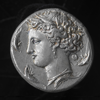

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, a stunning silver coin from the late 5th century BCE, renowned for its exquisite artistry and high relief, crafted by artists like Kimon and Euinatos. The coin's intricate design, including the intriguing figure of Dionysius, has captivated collectors for centuries. Notably, this piece was chosen by Theodore Roosevelt, an American president known for his reformative agenda, who was also passionate about the aesthetics of American currency. Comparing modern coins to classical masterpieces like the dekadrachm, Roosevelt recognized the need for a more artistic and engaging currency design. His efforts led to a collaboration with sculptor Augustus Saint-Gaudens, result

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


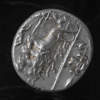

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, a stunning silver coin from the late 5th century BCE, renowned for its exquisite artistry and high relief, crafted by notable figures such as Kimon and Euinatos. This coin has captivated collectors for centuries, raising questions about the techniques used by the ancient Greeks to achieve such intricate designs without modern technology. Notably, this piece was utilized by Theodore Roosevelt, an American president known for his reformist agenda, who was dissatisfied with the mundane designs of contemporary coins. His desire for more artistic currency led him to compare modern American coins unfavorably to classical masterpieces like the dekadrac

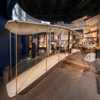

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1903 Wright Flyer, a groundbreaking aircraft that symbolizes the dawn of the powered flight era. Designed and built by Wilbur and Orville Wright, it is powered by a 12-horsepower engine and utilizes a unique sprocket-and-chain system to drive two pusher propellers. The Flyer's innovative design includes skids for landing and a non-wheeled structure. On December 17, 1903, Orville piloted the aircraft for its historic first flight, covering 36 meters (120 feet) in just 12 seconds. The Wright brothers' four-year research effort not only led to this remarkable achievement but also established foundational principles of aeronautical engineering, including the use of wind tunnels in design t

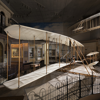

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1903 Wright Flyer, the first successful powered airplane to carry a pilot, designed by Wilbur and Orville Wright. The Flyer is powered by a 12-horsepower engine and utilizes a unique sprocket-and-chain system to drive two pusher propellers. Its innovative design includes skids for landing and a non-wheeled structure. The Flyer made its historic first flight on December 17, 1903, at Kitty Hawk, North Carolina, covering a distance of 36 meters (120 feet) in just 12 seconds. The Wright brothers' groundbreaking work in aeronautical engineering, including the development of wind tunnels, laid the foundation for modern aviation. This significant artifact was donated to th

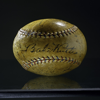

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an autographed baseball from the legendary 1926 New York Yankees, signed by Babe Ruth and Lou Gehrig. Ruth, a celebrated Hall of Famer, and Gehrig, who set a record for consecutive games played, are both pivotal figures in baseball history. Gehrig's battle with amyotrophic lateral sclerosis (ALS), often referred to as "Lou Gehrig's disease," showcased his remarkable character and humility, inspiring many. The baseball itself, made from a cork center, wool layers, and a horsehide cover, measures approximately 3 inches in diameter. While this significant artifact is part of the National Museum of American History's collection, it is currently not on display. For those interested in exploring

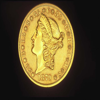

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin from the United States Mint in Philadelphia, minted in 1879, showcasing a Liberty head on the obverse and an eagle, emblazoned with the Latin motto DEO EST GLORIA, on the reverse. The coin's dimensions are 3.4 cm in height and 8.1 cm in width, and it is composed of a mix of copper alloy and gold plating. This particular coin is part of the National Museum of American History's collection, gifted by Harvey G. and Lawrence R. Stack, and is cataloged under the number 2001.0371.0001. The exhibit highlights the historical significance of this gold coin, which was part of a movement to boost the international competitiveness of American currency. Although this piece is cur

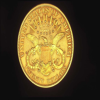

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin from the United States Mint in Philadelphia, dating back to 1879. The coin is notable for its design, which includes Liberty's head on the obverse and an eagle, emblazoned with the Latin motto DEO EST GLORIA, on the reverse. This design was part of a broader effort to enhance the international appeal of American coins, paralleling the introduction of the four-dollar gold Stella coin. Among a total of nine known surviving examples of this pattern, this particular piece is currently not on display but holds a significant place in the National Numismatic Collection. Measuring .2 cm in height and 3.4 cm in diameter, it is a key artifact in the study o

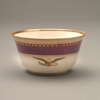

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, a poignant artifact from 1887, which was gifted to the Smithsonian's National Museum of American History by Lincoln Isham, the great-grandson of President Lincoln. The cup holds a compelling story; on April 14, 1865, just before heading to Ford's Theatre for the last time, Lincoln inadvertently left this cup behind on a windowsill. A White House servant preserved the cup as a memento of that tragic night. Years later, Captain D.W. Taylor presented the cup to Robert Todd Lincoln, Lincoln's eldest son, who cherished it as a family heirloom. The cup is crafted from ceramic and features a striking design with purple and gold trim, adorned with an eagle motif. Meas

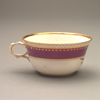

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: Abraham Lincoln's coffee cup, dating back to 1887, which was gifted to the Smithsonian's National Museum of American History by Lincoln Isham, the great-grandson of President Lincoln. The cup holds a poignant story; on April 14, 1865, just before heading to Ford's Theatre for the last time, Lincoln inadvertently left this cup on a windowsill. A White House servant preserved the cup as a relic of that tragic night. Years later, Captain D.W. Taylor presented the cup to Robert Todd Lincoln, Lincoln's eldest son, who cherished it as a family heirloom. The cup itself is crafted from ceramic and features a striking design in purple with white and gold 

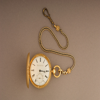

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary artifact: Helen Keller's Swiss touch watch, dating back to the late 1800s. Keller, who was born on June 27, 1880, is celebrated for her remarkable life as a deaf-blind individual who became a prominent advocate for women's rights and disability rights. After losing her senses at a young age, Keller was taught to communicate by her teacher, Anne Sullivan, and eventually graduated from Radcliffe College in 1904, making her the first deaf-blind person to earn a Bachelor of Arts degree. The watch, a gift from John Hitz in 1892, is a Swiss-made "touch watch" designed with pins around its edge to indicate the time, allowing Keller to tell time through touch. This watch holds sig

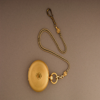

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: Abraham Lincoln's gold pocket watch, which dates back to the 1850s. While Lincoln was not known for his vanity, this watch served as a notable symbol of his success in his legal career. The watch's movement was crafted in Liverpool, a renowned watchmaking city, while the case was made by an unknown American manufacturer. A fascinating aspect of this watch is its hidden message engraved by watchmaker Jonathan Dillon during a repair on April 12, 1861. This engraving commemorates the Confederate attack on Fort Sumter and captures the historical moment. Dillon's inscription, along with a later addition by another watchmaker, remains a testament to th

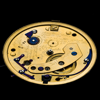

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this fine watch served as a testament to his success as a lawyer. The watch's movement, crafted in Liverpool—a center for watchmaking—is recognized for its high-quality standards, while the case was made in the United States. A unique aspect of this watch is the hidden engravings by two watchmakers, Jonathan Dillon and L. E. Gross, who left their names and the date of April 12, 1861, on the dial during the onset of the Civil War. This historical moment is poignantl

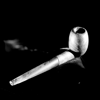

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Albert Einstein's pipe from around 1948, a significant artifact in the history of science. While Einstein is best known for his groundbreaking theory of relativity and his Nobel Prize, he also made a lasting impact in the area of smoking pipes. Despite health issues that limited his smoking in later life, he maintained a fondness for the tactile experience of holding a pipe. This particular pipe shows signs of extensive use, including a hole worn into the bit, and was gifted to Gina Plunguian, a close friend of Einstein. The Smithsonian acquired this item in 1979, and it is part of a larger collection of over 1,000 artifacts displayed at various Smithsonian Affiliates across the nation. Cu

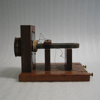

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History highlights the groundbreaking invention of the telephone by Alexander Graham Bell. He received the first patent for this innovative device on March 7, 1876, and just three days later, he made the first successful communication with his assistant, Thomas Watson. Among the key artifacts on display is one of the two telephones used during a landmark demonstration between Boston and Salem on November 26, 1876. This particular telephone is notable for its design, which includes an iron diaphragm and two electromagnets, and it lacks the wooden exterior found on many of its contemporaries. The Smithsonian acquired this significant piece from the American Telephon

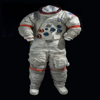

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apollo 17 spacesuit, an iconic artifact from the final Apollo mission that landed humans on the moon in December 1972. The mission was launched on December 7, 1972, by a Saturn V rocket and included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, who is notable for being the only geologist to have walked on the moon. While Evans remained in orbit, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region and conducted three moonwalks over three days, collecting 110 kilograms of lunar samples and driving a lunar rover for 35 kilometers. They also operated the lunar lander's life-support system for the first tim

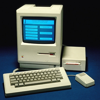

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apple "Classic" Macintosh Personal Computer, which was introduced by Apple Inc. in January 1984. This innovative computer was the first to incorporate a graphic user interface, allowing users to select programs by clicking on icons instead of relying on text-based command lines. The Macintosh was launched with great fanfare during Super Bowl XVIII, selling for about $2,500. It initially came with just 128K of RAM, but the release of the Macintosh 512 KB, known as "Fat Mac," in September 1984, significantly enhanced user experience by doubling the memory capacity. This model allowed for seamless multitasking, enabling users to run multiple applications at once. The Macintosh 512 KB was 

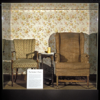

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an iconic piece of American history: the upholstered wing chair that belonged to Archie Bunker, played by Carroll O'Connor in the groundbreaking sitcom All in the Family. The chair, with its vibrant orange-yellow woven upholstery and sturdy wooden frame, dates back to the 1940s, although its exact maker and date are unknown. It was acquired from a thrift store in Southern California for use in the show and remained a key element until a reproduction was created for the final season after the original was donated to the Smithsonian. All in the Family, which aired from 1971 to 1979, was a revolutionary sitcom that tackled complex social issues, making it a cultural phenomenon of its time. Th

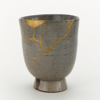

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite tea bowl from the 17th century, belonging to the White Satsuma ware category from Kagoshima prefecture, Japan. The bowl, crafted from stoneware and adorned with a clear, crackled glaze, showcases the artistry of kintsugi, a traditional Japanese repair technique that highlights rather than conceals damage. Kintsugi employs lacquer made from tree sap, which is toxic in its liquid form but completely safe once cured. This process not only ensures the bowl remains functional but also enhances its aesthetic appeal with golden reinforcements in the cracks, transforming the bowl into a work of art that celebrates its history. Kintsugi has been utilized in Asian ceramics for centuries

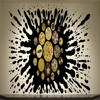

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the captivating works of Yinka Shonibare, a London-born artist whose creations explore themes of identity and cultural heritage. At the heart of the display is a striking arrangement of 25 circular canvases, each varying in size, arranged against a large-scale ink splatter pattern that has been meticulously applied with a template. The canvases are adorned with intricate foliate patterns in black and gold, executed on the edges or surfaces of Dutch wax printed fabrics. Shonibare's artistic journey is evident through his transition from grid-like square canvases to these dynamic roundels, which challenge conventional notions of edges and borders. The splatter technique references Africa's o

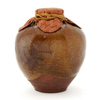

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable tea-leaf storage jar from the 17th century, originating from the Satsuma ware tradition in Kagoshima prefecture, Japan. The jar, crafted from stoneware and adorned with a distinctive orange-brown glaze, showcases a unique design with swirling patterns applied through the traditional Japanese technique known as kintsugi, or golden joinery. Unlike typical restoration methods that aim to hide damage, kintsugi embraces it, highlighting the jar's history while adding a beautiful aesthetic touch. The use of lacquer, a natural resin derived from tree sap, ensures that the repairs are not only durable but also water-resistant, making it a fitting choice for this type of object. Kintsu

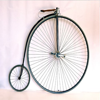

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an original 1886 Columbia Light Roadster high-wheel bicycle, a significant artifact in the history of cycling. Manufactured by the Pope Manufacturing Co., the first bicycle maker in the United States, this bicycle was sold for about $135 and offered in various sizes, including front wheel options of 47 and 59 inches paired with rear wheels of 16 or 18 inches. The bicycle on display is equipped with a 53-inch front wheel featuring 60 spokes and an 18-inch rear wheel with 20 spokes. Accompanying this bicycle is a historic group photograph from 1879, which captures one of the earliest organized biking tours in America, featuring Charles E. Pratt, the first president of the League of American 

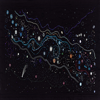

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features "Milky Way, Starry Night #2," a striking work by Margaret Nazon, a Gwich'in artist from Tsiigehtchic, Northwest Territories, Canada, created in 2021. Nazon's artistic journey began later in life, inspired by her childhood fascination with the stars and her experiences as a park ranger. This piece, characterized by swirling galaxies, represents a departure from traditional Gwich'in beadwork, showcasing Nazon's unique artistic voice. It is part of the "Lights Out: Recovering Our Night Sky" exhibition at the Smithsonian's National Museum of Natural History, which highlights the detrimental effects of light pollution on the night sky and its broader implications for ecosystems and human culture

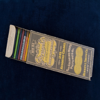

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a pack of Crayola Crayons from 1903, showcasing a beloved American invention that has enriched the childhood experience. The creation of these crayons was inspired by Edwin Binney and C. Harold Smith, who founded the Binney & Smith Company in Easton, Pennsylvania. They developed a safe and affordable coloring stick by using paraffin wax and non-toxic pigments, which were initially intended for adult use. However, the crayons' popularity surged among children, leading to their widespread adoption in schools and homes. The name "Crayola," coined by Alice Binney, combines the French word for chalk and a term for oily, reflecting the crayons' composition. This particular set, aimed at young ar

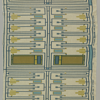

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking textile designed by the influential American architect Frank Lloyd Wright, who lived from 1867 to 1959. The piece, produced by F. Schumacher & Co., a prominent New York textile manufacturer established in 1889, showcases a geometric design that incorporates rectangular blocks of color in soothing shades of light blue and olive, along with darker olive and light gray. The textile measures 120 by 57.5 cm (47 1/4 by 22 5/8 in.) and is made from cotton, with a repeat height of 63.5 cm (25 in.). Attached to the upper back are samples of five alternate colorways, showcasing the versatility of the design. This textile is part of the Cooper Hewitt, Smithsonian Design Museum's collection

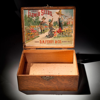

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an antique seed box from the 1890s, showcasing the historical significance of D.M. Ferry & Co. in the development of the “commission box” for retail display. As part of the Smithsonian Snapshot celebrating National Garden Month, this seed box is a poignant reminder of the marketing strategies adopted by seed companies in the 19th century. These companies, including D.M. Ferry & Co., created innovative display boxes that highlighted seed packets, making them visually appealing to customers. The design not only showcased the seeds but also served as a silent sales pitch, encouraging customers to purchase gardening supplies. This particular seed box is notable for its association with D.M. Fe

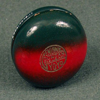

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the Smithsonian's National Museum of American History highlights the intriguing history of the yo-yo, a toy that gained immense popularity in America, largely due to the efforts of Chicago businessman Donald F. Duncan Sr. In 1928, Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant who had begun marketing the toy under the name “yo-yo,” which translates to “come-come.” By early 1929, Flores had established his own company and produced over 100,000 wooden yo-yos, understanding the importance of demonstrating the toy's tricks to entice buyers. Duncan, recognizing the toy's commercial potential, quickly acquired the righ

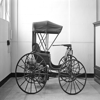

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1893-94 Duryea automobile, an iconic representation of early American automotive innovation. Frank Duryea conducted its historic road test on September 21, 1893, in Springfield, Massachusetts, utilizing a second-hand carriage fitted with a gasoline engine. The Duryea Motor Wagon Company, founded in 1896 by Frank, his brother Charles, and their investors, was the first company in the United States to manufacture and sell automobiles. The automobile is powered by a one-cylinder, four-cycle, four-horsepower water-cooled gasoline engine, which is positioned almost horizontally beneath the body. It features a gear transmission, which replaced the original friction system, as well as a spray

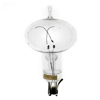

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Edison Light Bulb from 1879, a pivotal invention in the history of electric lighting. Thomas Edison's carbon-filament bulb revolutionized the way we illuminate our world, replacing the traditional gas lamps. The bulb operates by conducting an electric current through a metal filament, which heats up and produces light. To protect the filament from air exposure, it is sealed in a glass bulb filled with inert gas. This landmark demonstration took place at Edison's Menlo Park laboratory on New Year's Eve, 1879. Edison's contributions to technology are extensive, with a remarkable 1,093 patents to his name. His journey as an inventor was not without challenges, but he and his team were ins

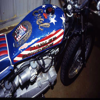

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Evel Knievel's iconic 1972 Harley-Davidson XR-750, a motorcycle that symbolizes the thrilling career of one of America's most famous daredevils. Evel Knievel, born Robert Craig Knievel, captivated audiences with his daring motorcycle stunts, many of which were performed at great heights and speeds. The XR-750, weighing about 300 pounds and made from steel, aluminum, and fiberglass, was instrumental in many of his most notable jumps, including a record leap over 14 Greyhound buses in 1975. Knievel's performances were not without peril; he suffered numerous injuries throughout his career, including 35 to 40 broken bones. This exhibit not only highlights the motorcycle but also celebrates the

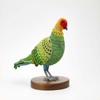

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features Laurel Roth Hope's “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This unique artwork employs humor to confront the serious issue of species extinction, allowing common rock pigeons to don crocheted suits that enable them to mimic extinct North American birds. While the concept may not restore biodiversity, it certainly invites reflection on the topic. Hope's artistic process involves traditional techniques such as carving, embroidery, crochet, and collage, transforming simple materials into intricate animal sculptures that are both playful and thought-provoking. Her work references the concept of the “vanishing spec

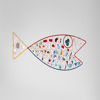

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features "Fish," a striking sculpture by Alexander Calder, created in 1945 and part of the Hirshhorn Museum and Sculpture Garden's collection in Washington, D.C. Calder, who was born into a family of artists, initially pursued a degree in mechanical engineering before fully committing to his artistic career. After working as a freelance illustrator, he moved to Paris, where he was influenced by avant-garde artists and began creating wire sculptures that critics described as “drawings in space.” In 1931, inspired by the simplicity of Piet Mondrian's studio, he invented the “mobile,” a kinetic sculpture that moves with air currents. He also created “stabiles,” which are static sculptures, and standing

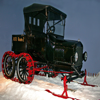

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a 1921 Ford Model T equipped with a snow attachment, illustrating the evolution of rural mail delivery in snowy conditions. In the early 1900s, rural mail carriers faced challenges navigating deep snow with their vehicles. To solve this problem, Virgil White developed a solution in 1906 by converting automobiles into snowmobiles, replacing front tires with skis and fitting the rear with caterpillar treads. This innovation allowed carriers to operate without the expense of horses and sleds during winter. White's first prototype utilized a Buick Model G, but as demand grew, he began producing kits for the popular Ford Model T. By 1922, these kits were sold for $250 to $400, and the Farm Spec

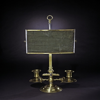

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact from American history: a brass candle stand that is closely tied to George Washington. After two successful terms as president, Washington chose to retire at Mount Vernon, where he crafted his Farewell Address in September 1796. This address, published in The American Daily Advertiser, served as Washington's final piece of guidance to the nation, urging Americans to prioritize unity over political divisions. The candle stand, with its adjustable reflector that amplifies candlelight, is believed to have been used by Washington while composing his address. This artifact was sold to the U.S. government in 1878 by the Lewis family, descendants of Washington's relatives, 

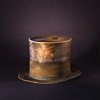

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features President Abraham Lincoln's top hat, a significant artifact housed at the Smithsonian's National Museum of American History. Standing at 6'4”, Lincoln was already a towering figure, and he chose to accentuate his stature with high top hats. This particular hat, made by Washington hat maker J.Y. Davis, features a black silk mourning band, a tribute to his son Willie, who died in 1862. While the exact date of acquisition is unknown, Lincoln last wore this hat on the evening of April 14, 1865, as he attended Ford's Theatre. Following his assassination, the War Department preserved Lincoln's personal items from the theatre, including this hat, which was transferred to the Patent Office before 

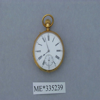

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this fine watch served as a testament to his success as a lawyer. The watch's movement was crafted in Liverpool, a renowned watchmaking city, while the case was made in the United States. Notably, it features an 18K gold case, indicating its high quality. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during the Civil War. Dillon's engraving, which includes the date "April 12, 1861," commemorates the attack on Fort Sumter. Additionally, another watchmaker, L. E. Gross, lat

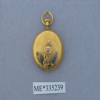

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: Helen Keller's touch watch, dating back to the late 1800s, which highlights her remarkable life as a disability rights advocate. Keller, who was born on June 27, 1880, became deaf and blind due to an illness, but with the help of her teacher, Anne Sullivan, she learned to communicate and achieved remarkable success. She became the first deaf-blind person to earn a college degree from Radcliffe College in 1904. The watch, a gift from John Hitz, is a Swiss-made device that allows time to be felt through pins on its edge, making it a perfect gift for Keller. This cherished possession symbolizes her independence and resilience, and she famously recov

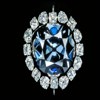

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., dating back to the early 19th century. The diamond, with its unique dark gray-blue coloration, is cut into a modified antique cushion shape, showcasing the luxurious craftsmanship of its time. This exquisite piece is set with 45 diamonds, totaling 50.5 carats, and is a significant example of high-quality jewelry design. It is part of the Mineral Sciences collection at the Smithsonian's National Museum of Natural History and is cataloged under the USNM Number NMNH G3551-00. This necklace not only represents the beauty of gemstones but also highlights the historical importance of jewelry making.
==> Ground truth answer: This exhibit features a st

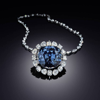

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem weighing an impressive 45.52 carats. The diamond, with its dark gray-blue color, is cut into a modified antique cushion shape, enhancing its unique visual appeal. This exquisite piece is set against a black velvet background, adding depth to its allure. The necklace is a significant artifact in the Mineral Sciences collection, specifically within the Gems category, and was last modified on September 26, 2022. It is cataloged with the USNM Number NMNH G3551-00 and an IGSN of NHB002JKJ within the NMNH - Mineral Sciences Department. For further details, you can access the original record [here](h

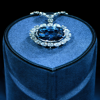

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: On display is a stunning diamond necklace featuring a single primary gem weighing an impressive 45.52 carats. This exquisite piece, cut into a modified antique cushion shape, showcases the luxurious dark gray-blue color that has made it a favorite among collectors. The diamond's origin from India contributes to its significance in the world of gemstones. This necklace is a remarkable example of high-quality craftsmanship, with a design that highlights the beauty of the gem while celebrating its historical significance. It is part of the Mineral Sciences collection at the Smithsonian's National Museum of Natural History and is cataloged under the USNM Number 

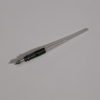

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an Esterbrook pen that holds historical significance as the instrument with which President Lyndon B. Johnson signed the Civil Rights Act of 1964 on July 2, 1964. Part of the Smithsonian's National Museum of African American History and Culture collection, this pen is one of over 7,000 identical pens that Johnson distributed to key figures in the Civil Rights Movement. The path to this landmark legislation was complex, having been initially proposed by President John F. Kennedy before his assassination in November 1963. President Johnson's commitment was crucial for the bill's success, as it faced a challenging journey through Congress, including the longest filibuster in history, lasting 

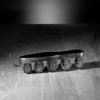

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito, an inline skate from 1823, designed by Robert John Tyers. As the Winter Olympics approach, it's fascinating to reflect on how athletes of the 19th century prepared for their sport without modern facilities. The Volito is notable for its unique design, which includes a wooden sole and a single row of five wooden wheels, along with a curved iron bar that functions as a basic brake. Its standout feature is the unequal wheel sizes—larger in the center and smaller at the ends—allowing for enhanced maneuverability during turns. This historical artifact is part of the National Museum of American History's collection and is currently not on display.
==> Ground truth answer: This exhibi

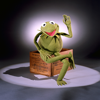

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Kermit the Frog, a character created by Jim Henson that has become synonymous with children's entertainment. Kermit first appeared in 1955 on the television program Sam and Friends and has since become the beloved host of The Muppet Show and a key figure on Sesame Street. Known for his calm demeanor amidst the chaos, Kermit's iconic song “Bein' Green” reflects on the challenges he faces due to his color while ultimately celebrating his unique identity. The puppet is made from a variety of materials, including synthetic fibers and felt, and measures 27 inches in height. This piece is part of the National Museum of American History's collection, thanks to a donation from Jim Henson Productio

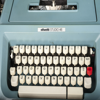

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), a pioneering science fiction author whose work has left a lasting impact on literature and culture. Butler is celebrated for her groundbreaking series, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the influential novels Parable of the Sower and Parable of the Talents, along with the short story collection Bloodchild and Other Stories. Her writing is characterized by a blend of African American history and speculative fiction, a genre that has become synonymous with Afrofuturism. By placing characters of African descent in the limelight of her early novels like 

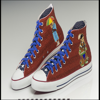

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Kiowa Ah-Day," a striking pair of sneakers created by Kiowa artist Teri Greeves in 2004. The sneakers are made from cotton canvas and adorned with intricate beadwork, showcasing a blend of traditional Native American artistry and modern fashion. With dimensions of 33 x 11 x 15 cm, this work exemplifies the intersection of culture and contemporary art. The National Museum of the American Indian acquired this piece from Thirteen Moons Gallery in Santa Fe, New Mexico, in 2004, highlighting the ongoing dialogue between indigenous heritage and modern expression.
==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004

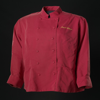

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant collection from the Smithsonian's National Museum of African American History and Culture, generously donated by Dooky Chase's Restaurant and Chef Leah Chase. Known as “The Queen of Creole Cuisine,” Chase played a crucial role in elevating New Orleans Creole cooking to international acclaim. She famously stated, “We changed the world over a bowl of gumbo,” reflecting the transformative impact of her restaurant gatherings. Together with her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop into a fine-dining experience, complete with elegant white tablecloths and prominent works by African American artists. The exhibit features Chase's disti

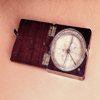

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant pocket compass that belonged to William Clark, a key figure in the Lewis and Clark Expedition. Made by Thomas Whitney in Philadelphia, the compass is a silver-plated brass instrument with a graduated rim and two small brass sight vanes, all housed in a mahogany box with a leather carrying case. It is believed that Clark acquired this compass in preparation for the expedition, which began in May 1804. The Corps of Discovery, led by Meriwether Lewis, aimed to explore uncharted territories and establish diplomatic relations with Native American tribes. Over the course of three years, they traveled over 8,000 miles, facing numerous challenges and documenting their experiences in 

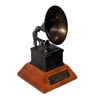

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1960 Grammy Award of Bob Newhart, a celebrated comedian and actor known for his deadpan humor. Born on September 5, 1929, in Oak Park, Illinois, Newhart has enjoyed a successful career spanning over sixty years. His debut comedy album, The Button-Down Mind of Bob Newhart, made history as the first comedy LP to top the Billboard charts and won him a Grammy for Album of the Year, along with the honor of being the only comedian to receive the Grammy for Best New Artist. Newhart's television legacy includes starring roles in iconic sitcoms like The Bob Newhart Show and Newhart, which have left a lasting impact on the sitcom genre. He continued to make his mark on television into his 90s, e

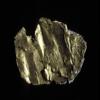

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant gold nugget from 1848, housed at the Smithsonian's National Museum of American History. It is believed to be the first gold piece discovered at Sutter's Mill in California, an event that sparked the gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall discovered a shiny object in the mill's tailrace. Upon inspection, he identified it as a thin scale of pure gold. Later that year, Marshall's discovery was presented to Capt. Joseph L. Folsom, who documented it as Specimen No. 1, marking it as the first gold find in Northern California. By August 1848, this nugget and other samples were sent to Washington, D.C., where President James K. 

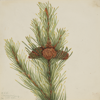

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a watercolor painting by Mary Vaux Walcott, titled "Lodgepole Pine (Pinus Contorta murrayana)," created in 1921. Measuring 10 x 7 inches, this piece is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began after a botanist requested her to depict a rare arnica flower. In 1913, she married Charles Doolittle Walcott, the then Secretary of the Smithsonian, and spent summers in the Canadian Rockies, where she produced numerous watercolor studies of local flora. Between 1925 and 1929, her illustrations were published in a five-volume series titled "North American Wild Flowers," and she later illustrated "North

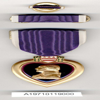

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the esteemed United States Purple Heart, a medal that symbolizes military honor. The medal is crafted in a heart shape from gold, showcasing a striking profile relief of George Washington at its center. Above the bust, a shield with Washington's family coat of arms is prominently displayed. The reverse side of the medal is inscribed with the phrase "FOR MILITARY MERIT," signifying its prestigious award criteria. It is attached to a silk ribbon that is purple with a white edge stripe, enhancing its visual appeal. The Purple Heart is made from a combination of materials, including copper alloy, silk, gold plating, and non-magnetic white metal alloy. This particular medal, measuring 3.7 cm by

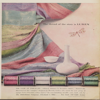

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an advertisement from the 1950s, showcasing the work of Dorothy Liebes (1897–1972), an influential American textile designer. Liebes is celebrated for her innovative contributions to various design fields, including fashion, interiors, and film. Her signature style, known as the “Liebes Look,” is characterized by vibrant colors, rich textures, and metallic accents, which became iconic during the mid-20th century. Throughout her career, Liebes collaborated with notable figures in design, such as Frank Lloyd Wright and fashion designers like Adrian, creating iconic pieces that defined the aesthetic of modern America. Although she was celebrated during her lifetime, the full extent of her inf

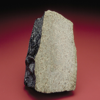

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Nakhla Meteorite Fragment at the Smithsonian's National Museum of Natural History, a significant specimen among the thirty-four known meteorites that have originated from Mars. The Nakhla meteorite fell on June 28, 1911, in the Nakhla region of Alexandria, Egypt, where it was observed exploding in the atmosphere before breaking into approximately forty pieces, with a total weight of 22 pounds. Many of these fragments were found buried up to a meter deep. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a 480-gram fragment, bringing its total collection to 650 grams by the 1970s. The Nakhlites, a term referring to Martian meteorites named after Nakhla, 

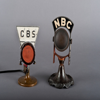

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an RCA Type 50-A microphone, a significant artifact from the era of President Franklin D. Roosevelt's "Fireside Chats." Beginning on March 12, 1933, these informal radio broadcasts allowed Roosevelt to communicate directly with the American people, addressing their concerns during the Great Depression. With unemployment at an all-time high and a faltering banking system, Roosevelt's ability to reassure and inspire became a vital tool in navigating the crisis. The first chat took place in the Lincoln Study, while later broadcasts were held in the Diplomatic Reception Room of the White House. This particular microphone, which showcases the National Broadcasting Company logos, was preserved b

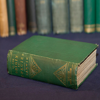

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "On the Origin of Species," authored by Charles Darwin in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the anniversary of the HMS Beagle's launch on May 11, 1820, a vessel that played a crucial role in Darwin's scientific discoveries. The Beagle was launched from Woolwich Dockyard in London and underwent several modifications before embarking on its second survey voyage on December 27, 1831. Darwin, a young naturalist, was brought on board to provide geological expertise. Over five years, the expedition to South America and the Galápagos Islands allowed Darwin to gather fossils, study plant specimens, and analyze geological formations, which ultima

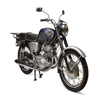

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Robert M. Pirsig's 1966 Honda Super Hawk motorcycle, a key artifact from his influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book sold over a million copies in its first year alone and initiated a global cultural movement that encouraged individuals to reassess their relationships with technology and seek a more balanced life. Pirsig's inspiration came from a transformative road trip he took with his son Chris in 1968, covering 5,700 miles from Minnesota to San Francisco. This journey not only strengthened their father-son bond but also provided Pirsig with deep insights into self-awareness and the nature of existence. The book'

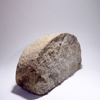

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Plymouth Rock Piece from 1620, an iconic artifact at the National Museum of American History. Traditionally regarded as the landing site of the Mayflower Pilgrims, Plymouth Rock is steeped in history. The rock's origins are somewhat mysterious, but it is believed to have been moved from its original location in the 1700s to its current spot on the shore of Plymouth Harbor. In 1880, a significant piece was discovered being used as a doorstep by the Plymouth Antiquarian Society, which was later broken into three parts. One of these pieces was donated to the Smithsonian in 1984, and museum officials accepted it in 1985. This rock fragment, measuring 22 inches by 11.5 inches, is composed o

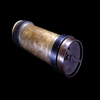

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Pneumatic Mail Container from 1953, housed at the Smithsonian's National Postal Museum. It highlights the remarkable pneumatic tube systems that emerged in the late 1800s, designed to transport mail swiftly beneath city streets. Each canister, or carrier, could hold up to 500 letters and was propelled through the tubes by compressed air, reaching an average speed of 35 miles per hour while spinning. At its peak, the system managed to move an impressive six million pieces of mail daily, with five carriers dispatched every minute. The first pneumatic tubes were introduced in Philadelphia in 1893, followed by a launch in New York City in 1897, and eventually expanded to cities like Boston

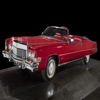

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the iconic 1973 red Cadillac Eldorado that belonged to the esteemed rock 'n' roll artist Chuck Berry. The Cadillac is a significant part of the Smithsonian's National Museum of African American History and Culture collection, having been donated by Berry himself in 1996. It is a key artifact in the museum's “Musical Crossroads” exhibition. The Cadillac was not only a personal vehicle for Berry but also a central element in the 1987 documentary Hail! Hail! Rock 'n' Roll, which celebrated his 60th birthday through two concerts. A memorable moment in the film is when Berry drives this Cadillac onto the stage of the Fox Theater in St. Louis, a venue that had previously denied him entry as a ch

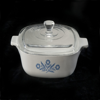

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a classic white casserole dish from CorningWare, dating back to 1965, adorned with the brand's iconic blue cornflower design. The dish is made from Pyroceram, a revolutionary material that was initially developed for military applications during World War II. Its unique glass-ceramic composition allows it to withstand rapid temperature shifts while resisting stains and odors, making it a versatile choice for cooking, freezing, and serving. In the 1990s, CorningWare shifted towards ceramic stoneware to meet consumer demand for more colorful and varied designs, but the original glass-ceramic line was reintroduced in 2009 due to its enduring popularity. This particular dis

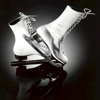

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the autographed ice skates of Sonja Henie, a legendary Norwegian figure skater from around 1945. Henie was a trailblazer in women's figure skating during the late 1920s and 1930s, introducing white leather skates to the sport, a significant departure from the traditional black skates. She captivated audiences with her innovative choreography and captured nine world titles, winning her first in 1927. Henie's performances were groundbreaking, combining dance with skating, and she was the first to popularize the short skirt and white skates that are now standard in the sport. Her Olympic accolades include gold medals in ladies singles at the Winter Olympics held in 1928, 1932, and 1936. Henie

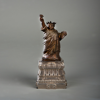

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Produced in the United States, this statuette was created in large quantities to finance the construction of the statue's pedestal in New York Harbor. The design, crafted by French sculptor Frédéric-Auguste Bartholdi, was made available in both six-inch and twelve-inch sizes, with the six-inch model priced at one dollar and the twelve-inch model at five dollars. A national campaign promoted these models, with the six-inch version sold in the thousands and the twelve-inch version sold in the hundreds. Richard Butler, a rubber manufacturer from New York, led the American Committee responsi

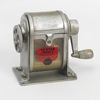

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Dexter Model 3 Pencil Sharpener, dating back to approximately 1920, produced by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. Constructed from metal, cellulose, and painted wood, this sharpener measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.) and is part of the Cooper Hewitt, Smithsonian Design Museum collection, thanks to a gift from Lucy Commoner. The Dexter sharpener, which evolved from the original introduced in 1914, featured a rotating wheel with calibrated openings for various pencil sizes, enhancing its functionality. By the 1920s, APSCO had produced a range of similar sharpeners, each with unique designs and pricing. Its success is attributed

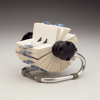

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Rolodex Open Rotary Card File, a staple of office organization that has stood the test of time. Manufactured by the Rolodex Corporation in the USA, this particular model is made from a combination of materials including bent tubular metal, molded plastic, rubber, and paper, with dimensions of 18 x 18 x 16.5 cm. The Rolodex operates on a cylindrical mechanism that allows users to rotate through A-Z index cards, facilitating easy access to business contacts. Despite the digital shift, the Rolodex remains a popular choice for those who appreciate its tactile nature and simple functionality. Invented by Arnold Neustadter, a pioneer in office supply innovation, the Rolod

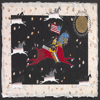

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features "Lakota Horse Mask," a striking work by Jim Yellowhawk, created in 2008 and belonging to the Cheyenne River Lakota tribe. This piece, made with acrylic on paper and adorned with gold leaf, showcases the artist's unique approach to capturing the essence of horses in Native American culture. Horses have historically played a vital role in the lives of many tribes, serving as both companions and essential allies in various aspects of daily life. The mask is part of the Smithsonian's National Museum of the American Indian collection and is featured in the online exhibition “Horse Nation.” Visitors can also access a video that explores the significance of horses in Native cultures, part of the m

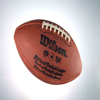

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wilson Duke football, a key artifact from Super Bowl XIV, held on January 20, 1980, at the Rose Bowl in Pasadena, California. The Wilson Sporting Goods Company introduced this football in the early 1940s, featuring premium leather and a unique design with sewn ends and lock-stitch seams. Since Super Bowl II in 1968, it has been the official ball of the NFL championship game. The football on display was used during a thrilling matchup where the Pittsburgh Steelers faced off against the Los Angeles Rams, resulting in a Steelers victory of 31-19. This win marked the Steelers' fourth Super Bowl title and highlighted Terry Bradshaw's performance, earning him the Most Valuable Player award f

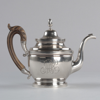

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a beautifully crafted silver teapot by Peter Bentzon, an American artisan active from around 1817 to after 1850. The teapot showcases an elegant oval vase shape that rests on a spreading pedestal foot. It is adorned with a gracefully curved spout, capped with an incised patera, and a scroll handle that is finished with a wooden leaf cap. The hinged domed cover is topped with an acorn finial, adding a playful touch to this exquisite piece. Notably, the teapot is engraved with the monogram "MC" and the name "Rebecca Dawson" on the bottom rim, revealing its historical significance. This artifact is part of the collection at the Smithsonian National Museum of African American History and Cultu

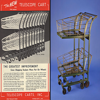

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History features the Telescoping Shopping Cart, an invention from 1949 by Orla E. Watson. As the holiday shopping rush commences, it's fascinating to reflect on how this design has transformed the shopping experience. Watson's design allows for efficient stacking, with each parked cart requiring only one-fifth of the space of a traditional cart. The first iteration of this cart made its debut in 1947 at Floyd's Super Market in Kansas City. This exhibit is part of the Smithsonian's first major showcase on food history, which highlights the significant shifts in food consumption and shopping practices in postwar America. For additional insights into the evolution of

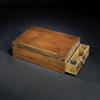

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Thomas Jefferson's portable writing desk, a crucial artifact from the creation of the Declaration of Independence in 1776. Jefferson, a key delegate from Virginia, was chosen to draft this foundational document, which was adopted by the Continental Congress on July 4. The desk, designed with a hinged writing board and a locking drawer for storing writing essentials, symbolizes Jefferson's commitment to the ideals of liberty and democracy. Throughout his life, he used this desk in various roles, including as a president and diplomat, and he even inscribed a personal message under the writing board in 1825. In 1876, after Jefferson's death, the desk was given to his granddaughter, Eleanora R

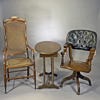

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an important artifact from American history: the chair used by General Ulysses S. Grant during the surrender negotiations with General Robert E. Lee at Appomattox Court House, Virginia, on April 9, 1865. This meeting was crucial in determining the fate of Lee's troops and effectively marked the end of the Civil War. The chair, made of wood and measuring 37.5 inches in height, is a symbol of this pivotal event. It was taken as a memento by General E. W. Whitaker, who recognized its historical significance. In 1888, Whitaker's heirs donated the chair to the Smithsonian Institution, where it was initially stored in the Patent Office before being transferred to the National Museum of American 

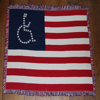

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a hand-altered lap blanket that incorporates the universal access symbol, a tribute to the advocacy efforts of the American Disabled for Attendant Programs Today (ADAPT). The blanket, made from cotton and measuring 129 cm by 95 cm, is a poignant representation of the fight for civil rights among disabled individuals. ADAPT, founded in 1983 in Denver, emerged from the post-World War II disability rights movement, which saw individuals with disabilities unite to share their experiences and push for political change. The blanket's design, with its stitched stars, powerfully conveys the message that civil rights are an essential entitlement for all. Although this piece is currently not on disp

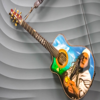

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the guitar of Carlos Vives, a Grammy Award-winning Colombian singer and composer renowned for his vallenato music. Vallenato, a vibrant genre from Colombia's Atlantic coast, blends European instruments like the accordion with poetic storytelling and the traditional rhythms of the Arhuaco indigenous people. Historically, this music was performed by rural workers and cowboys, remaining largely local until the 1990s when Vives and other artists began to incorporate pop and rock elements, allowing it to resonate with audiences worldwide. The guitar on display, crafted by a Colombian luthier, features an airbrushed portrait of an Arhuaco and was last played by Vives during a concert at the Holl

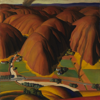

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a captivating painting by Ross Dickinson, an artist whose work emerged from the Public Works of Art Project during the Great Depression. Created against the backdrop of the Dust Bowl, the painting captures the lushness of California's Central Valley, where a river meanders through vibrant green fields, symbolizing the promise of a better life for those escaping the devastation of the Midwest. However, Dickinson's portrayal is layered with meaning, as he incorporates elements of danger—like a small controlled fire and a larger smoke plume in the background—reminding viewers that the idyllic landscape is not without peril. This artwork not only reflects the hopes of those seeking a new begin

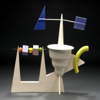

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the innovative work of Peter Shire, an artist born in Los Angeles in 1947. One of the standout pieces is the Weathervane Teapot, created in 1981, which exemplifies Shire's unique approach to ceramic art. The teapot is characterized by its playful design, incorporating colorful shapes such as squares and spheres, along with whimsical rods and hollow tubes. Shire's intention was to challenge traditional, class-based perceptions of "tea-time," making it a practice that is accessible to everyone. The teapot's unconventional construction invites viewers to engage with it, raising questions about its functionality and how to handle it. After 1985, Shire shifted his focus to furniture design, mar

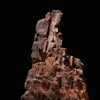

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Spotsylvania tree stump, a poignant artifact from the Civil War, specifically from 1864–65, located at the Smithsonian's National Museum of American History. The stump is all that remains of a once-magnificent oak tree that stood in a peaceful meadow near Spotsylvania Court House, Virginia. On May 12, 1864, this tranquil setting was transformed into a battlefield as Confederate forces under Gen. Robert E. Lee clashed with Union troops from the Army of the Potomac. The ensuing violence left its mark on the oak, with several Minié balls still embedded in the wood, serving as a stark reminder of the brutality of war. This stump was originally presented to the U.S. Army's Ordnance Museum b

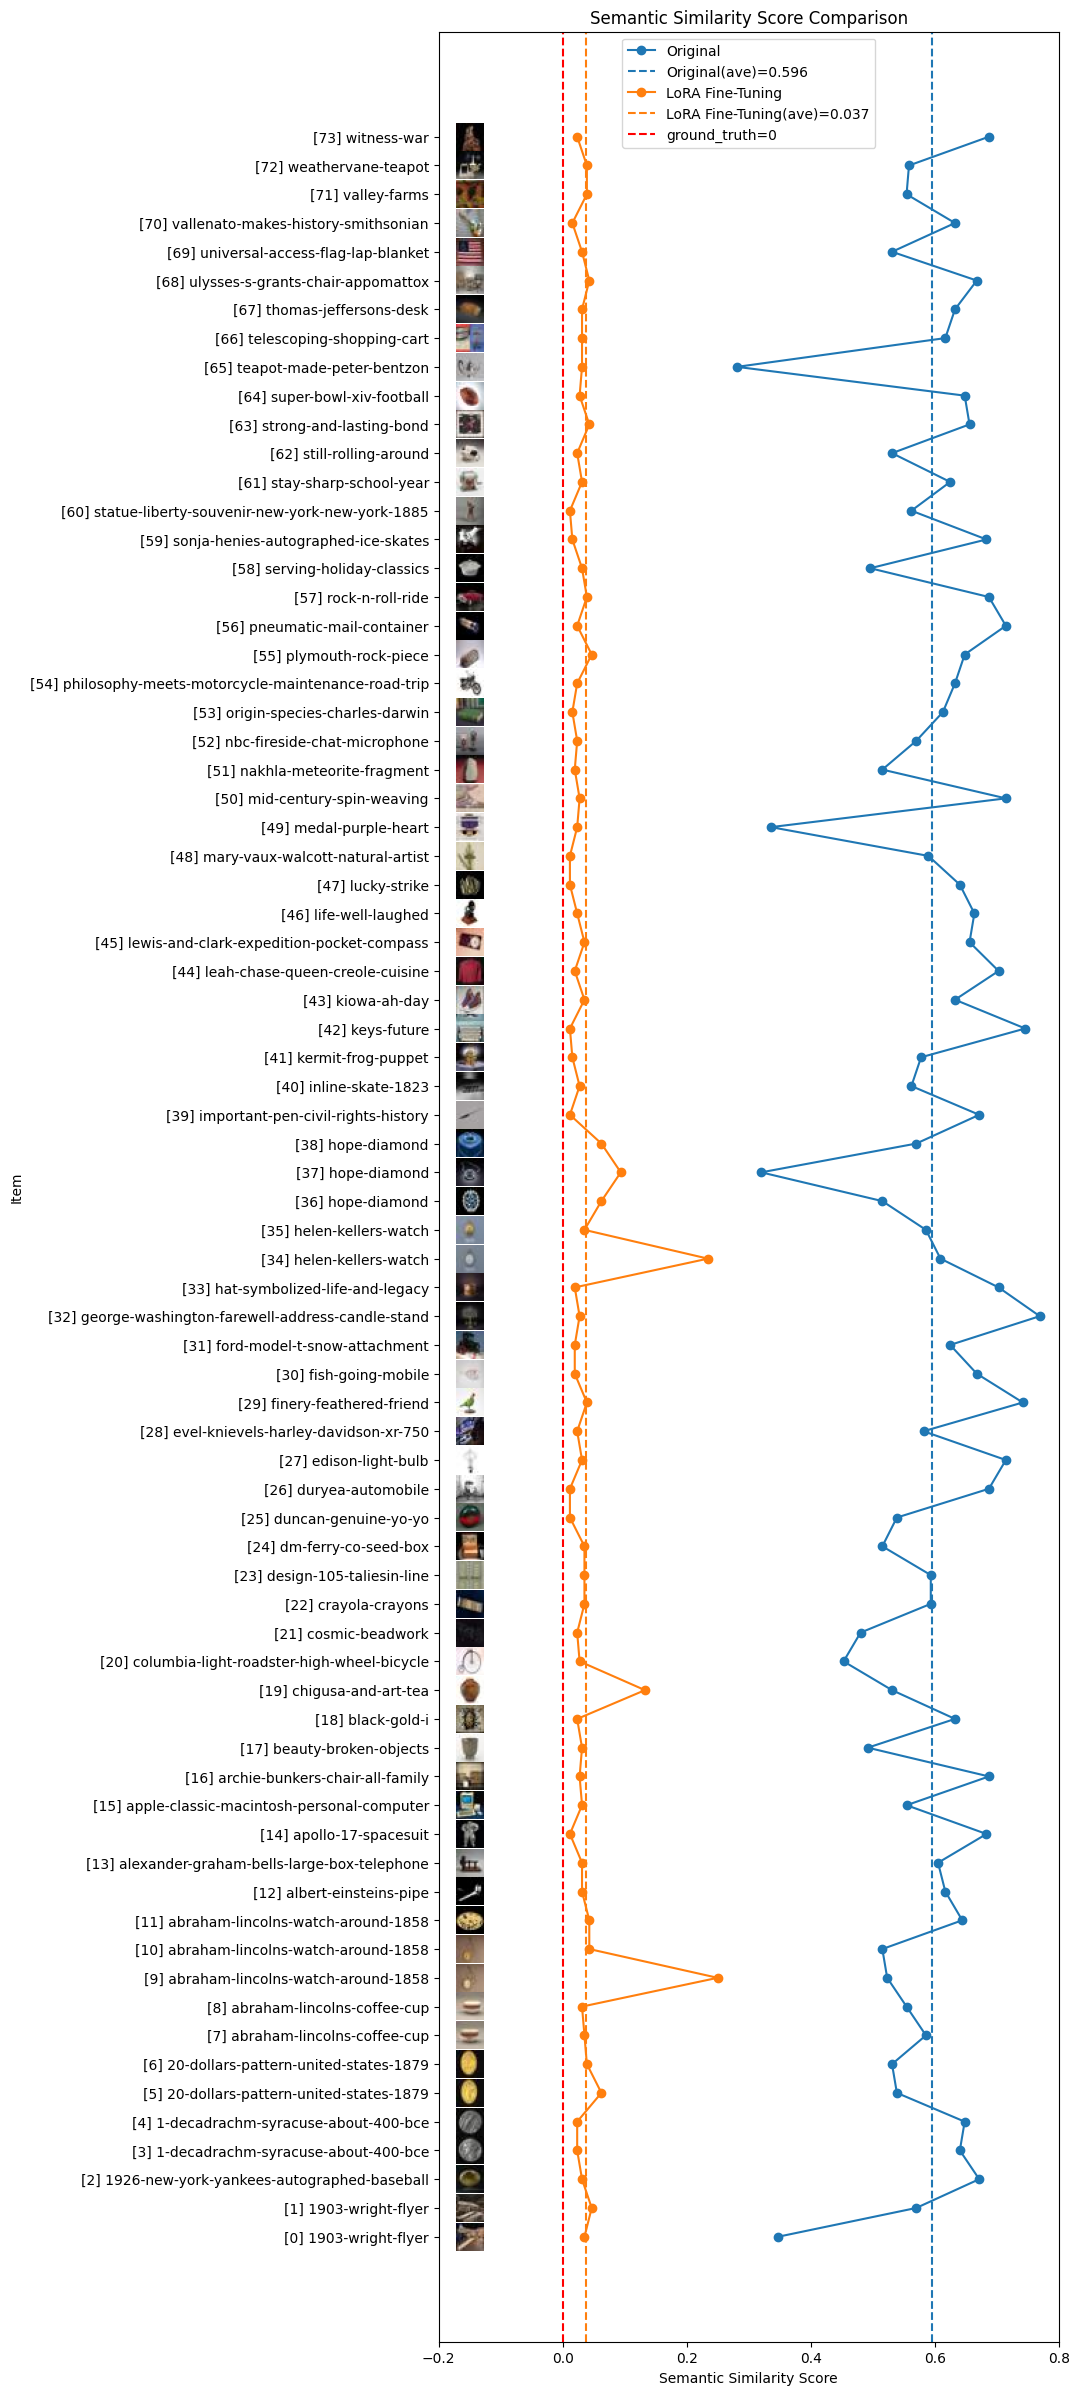

In [2]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(lora_model, processor, dataset['test'], './results/inference_results/inference_results_after_finetuning.csv', 14)

# Plot similarity scores (original vs. fine-tuned) from the inference CSV files, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv'),
                                 ('LoRA Fine-Tuning', './results/inference_results/inference_results_after_finetuning.csv')],
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_after_finetuning.jpg')


## 4.4 Save the Fine-Tuned Model Locally  

Use `save_pretrained()` from Hugging Face to:

- Save Processor: [HF Documentation](https://huggingface.co/docs/transformers/main_classes/processors#transformers.ProcessorMixin.save_pretrained)  
  During processor saving, the processor's `config`, `chat template`, and `token list` are saved.

- Save Fine-Tuned Model: [HF Documentation](https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.save_pretrained)  
  During fine-tuned model saving, the model's `weights`, `config`, and `generation config` are saved.


In [3]:
# Merge base model with LoRA adapter
print(f'==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...')
merged_model = lora_model.merge_and_unload()

# Save processor
print(f'==> Saving processor...')
my_utils.print_processor_info_to_file(processor, './results/model_info/updated_processor_info.txt')
processor.save_pretrained(save_directory='./results/finetuned_model')

# Save fine-tuned model
print(f'==> Saving fine-tuned model...')
my_utils.print_model_info_to_file(merged_model, './results/model_info/finetuned_model_info.txt')
my_utils.print_model_parameters_to_file(merged_model, './results/model_info/finetuned_model_parameters.txt')
merged_model.save_pretrained(save_directory='./results/finetuned_model')


==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...
==> Saving processor...
==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32004, bos_token: <s>, eos_token: </s>, pad_token: <pad>
==> For complete processor info, refer to ./results/model_info/updated_processor_info.txt.
==> Saving fine-tuned model...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/finetuned_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
model.vision_model.e

## 4.5 (Optional) Push the Fine-Tuned Model to the Hugging Face Hub  

Use `push_to_hub()` from Hugging Face to:

- Upload Processor: [HF Documentation](https://huggingface.co/docs/transformers/main_classes/processors#transformers.ProcessorMixin.push_to_hub)  

- Upload Fine-Tuned Model: [HF Documentation](https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.push_to_hub)

In [4]:
print(f'==> Pushing processor and fine-tuned model to Hugging Face...')
processor.push_to_hub(repo_id='xugefu/musequest_finetuned_model')
merged_model.push_to_hub(repo_id='xugefu/musequest_finetuned_model', max_shard_size="5GB", safe_serialization=True)


==> Pushing processor and fine-tuned model to Hugging Face...


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/xugefu/musequest_finetuned_model/commit/ab771dd31ba347fc9b7754a8f3c937a7efecf06c', commit_message='Upload Idefics2ForConditionalGeneration', commit_description='', oid='ab771dd31ba347fc9b7754a8f3c937a7efecf06c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xugefu/musequest_finetuned_model', endpoint='https://huggingface.co', repo_type='model', repo_id='xugefu/musequest_finetuned_model'), pr_revision=None, pr_num=None)